# <center> **Edinbrugh Airbnb**</center>

For this project I will assume the role of a **Revenue Manager**, which will be centered on maximizing revenue through the implementation of data-driven strategies.

This type of presentation would be highly relevant in a professional setting, such as a meeting with the revenue management team of a short-term rental platform like Airbnb, a hospitality consultancy firm, or a property management company. The audience could include senior managers, property owners, or stakeholders interested in actionable strategies to maximize profitability. By presenting these analyses, I would equip the decision-makers with insights to refine pricing policies, allocate marketing budgets effectively, and enhance overall revenue growth.

## **Phase 1: Data Understanding and Initial Exploration**

#### **Step 1: Define Objectives**

- Maximize revenue through pricing strategies and occupancy optimization.
- Identify patterns and trends in demand and revenue across Edinburgh.
- Leverage ML for predictive and prescriptive analytics.

#### **Step 2: Explore the Dataset**

**Key Questions:**
- How is pricing distributed across neighborhoods, seasons, and room types?
- What factors influence revenue (e.g., reviews, amenities, neighborhood)?
- Are there any temporal patterns in booking availability or cancellations?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import gzip
import shutil

from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import spacy

import ast
import re

from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from scipy.stats import f_oneway

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

##### **Data Decompression:**

Due to the large size of the data files, the original files have been comressed. In order to access the data you must first decompress it using the code below.

In [ ]:
# Function to decompress a .gz file
def decompress_gz(input_file, output_file):
    with gzip.open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# List of compressed files and their output names
files_to_decompress = [
    ('calendar.csv.gz', 'calendar.csv'),
    ('listings.csv.gz', 'listings.csv'),
    ('reviews.csv.gz', 'reviews.csv'),

]

# Decompress each file
for input_file, output_file in files_to_decompress:
    decompress_gz(input_file, output_file)
    print(f"Decompressed {input_file} to {output_file}")

Decompressed calendar.csv.gz to calendar.csv
Decompressed listings.csv.gz to listings.csv
Decompressed reviews.csv.gz to reviews.csv


Loead the uncompressed datasets, only the first time you run the project code, after performing the data cleaning processes, skip these steps and load the cleaned data directly.  

In [ ]:
# Load datasets
calendar_df = pd.read_csv('calendar.csv')
listings_df = pd.read_csv('listings.csv')
neighbourhoods_df = pd.read_csv('neighbourhoods.csv')
reviews_df = pd.read_csv('reviews.csv')
s_listings_df = pd.read_csv('S_listings.csv')
s_reviews_df = pd.read_csv('S_reviews.csv')

**Important:** Load the pre-cleaned files directly in subsequent sessions:

In [2]:
# Load cleaned datasets
listings_df = pd.read_csv("cleaned_listings.csv")
calendar_df = pd.read_csv("cleaned_calendar.csv")
neighbourhoods_df = pd.read_csv('neighbourhoods.csv')
reviews_df = pd.read_csv("cleaned_reviews.csv")
s_listings_df = pd.read_csv("cleaned_S_listings.csv")
s_reviews_df = pd.read_csv('S_reviews.csv')
merged_data = pd.read_csv("cleaned_merged_data.csv", low_memory=False)

##### **Data Preview:**

Here are the previews of the original datasets, before cleaning. 

In [29]:
print("Calendar Data:")
calendar_df.info()
calendar_df.head()

Calendar Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109562 entries, 0 to 2109561
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  float64
 5   minimum_nights  int64  
 6   maximum_nights  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 112.7+ MB


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3676452,2024-09-13,f,$120.00,NaN,3,1125
1,3676452,2024-09-14,f,$120.00,NaN,3,1125
2,3676452,2024-09-15,f,$120.00,NaN,3,1125
3,3676452,2024-09-16,f,$120.00,NaN,3,1125
4,3676452,2024-09-17,t,$120.00,NaN,3,1125


In [30]:
print("\nListings Data:")
listings_df.info()
listings_df.head()


Listings Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5780 entries, 0 to 5779
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5780 non-null   int64  
 1   listing_url                                   5780 non-null   object 
 2   scrape_id                                     5780 non-null   int64  
 3   last_scraped                                  5780 non-null   object 
 4   source                                        5780 non-null   object 
 5   name                                          5780 non-null   object 
 6   description                                   5656 non-null   object 
 7   neighborhood_overview                         3552 non-null   object 
 8   picture_url                                   5780 non-null   object 
 9   host_id                                       5

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15420,https://www.airbnb.com/rooms/15420,20240913130419,2024-09-13,city scrape,Georgian Boutique Apt City Centre,"Stunning, spacious ground floor apartment minu...","The neighbourhood is in the historic New Town,...",https://a0.muscache.com/pictures/cf69631f-4194...,60423,...,4.99,4.98,4.92,NaN,f,1,1,0,0,3.49
1,24288,https://www.airbnb.com/rooms/24288,20240913130419,2024-09-13,city scrape,"Cool central Loft, sleeps 4, 2 double bed+en-s...",Upper level of duplex. Boho rustic-chic former...,"Boho, studenty, lively, cool neighbourhood",https://a0.muscache.com/pictures/3460007/88731...,46498,...,4.91,4.85,4.67,NaN,f,1,1,0,0,1.98
2,38628,https://www.airbnb.com/rooms/38628,20240913130419,2024-09-13,city scrape,Edinburgh Holiday Let,Self contained studio 6 minutes by train to Ed...,Quiet and easy access to outside. Fort Kinnair...,https://a0.muscache.com/pictures/miso/Hosting-...,165635,...,4.77,4.73,4.75,EH-70886-F,t,1,1,0,0,0.58
3,48645,https://www.airbnb.com/rooms/48645,20240913130419,2024-09-13,city scrape,Large sunny room on Royal Mile,The apartment is directly on the Royal Mile ab...,The Canongate is an area rich in culture and h...,https://a0.muscache.com/pictures/miso/Hosting-...,221474,...,4.94,4.97,4.78,EH-70355-F,t,1,0,1,0,6.42
4,51505,https://www.airbnb.com/rooms/51505,20240913130419,2024-09-13,city scrape,Superb City Centre Apartment,Fantastically central apartment in an historic...,Hanover Street is wonderfully located in the c...,https://a0.muscache.com/pictures/bc26fbc9-38a3...,236828,...,4.95,4.95,4.71,NaN,t,12,12,0,0,0.51


In [31]:
print("\nNeighbourhoods Data:")
neighbourhoods_df.info()
neighbourhoods_df.head()


Neighbourhoods Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   neighbourhood_group  0 non-null      float64
 1   neighbourhood        111 non-null    object 
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


,neighbourhood_group,neighbourhood
0,NaN,Abbeyhill
1,NaN,Baberton and Juniper Green
2,NaN,Balerno and Bonnington Village
3,NaN,Balgreen and Roseburn
4,NaN,"Barnton, Cammo and Cramond South"


In [32]:
print("\nReviews Data:")
reviews_df.info()
reviews_df.head()


Reviews Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543103 entries, 0 to 543102
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     543103 non-null  int64 
 1   id             543103 non-null  int64 
 2   date           543103 non-null  object
 3   reviewer_id    543103 non-null  int64 
 4   reviewer_name  543103 non-null  object
 5   comments       543060 non-null  object
dtypes: int64(3), object(3)
memory usage: 24.9+ MB


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,15420,171793,2011-01-18,186358,Nels,My wife and I stayed at this beautiful apartme...
1,15420,176350,2011-01-31,95218,Gareth,Charlotte couldn't have been a more thoughtful...
2,15420,232149,2011-04-19,429751,Guido,I went to Edinburgh for the second time on Apr...
3,15420,236073,2011-04-23,420830,Mariah,This flat was incredible. As other guests have...
4,15420,263713,2011-05-15,203827,Linda,Fantastic host and the apartment was perfect. ...


In [33]:
print("\nSimplified Listings Data:")
s_listings_df.info()
s_listings_df.head()


Simplified Listings Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5780 entries, 0 to 5779
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              5780 non-null   int64  
 1   name                            5780 non-null   object 
 2   host_id                         5780 non-null   int64  
 3   host_name                       5780 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   5780 non-null   object 
 6   latitude                        5780 non-null   float64
 7   longitude                       5780 non-null   float64
 8   room_type                       5780 non-null   object 
 9   price                           4873 non-null   float64
 10  minimum_nights                  5780 non-null   int64  
 11  number_of_reviews               5780 non-null   int64  
 12  last_re

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,15420,Georgian Boutique Apt City Centre,60423,Charlotte,NaN,"Old Town, Princes Street and Leith Street",55.957590,-3.188050,Entire home/apt,145.0,3,580,2024-09-10,3.49,1,181,69,NaN
1,24288,"Cool central Loft, sleeps 4, 2 double bed+en-s...",46498,Gordon,NaN,"Canongate, Southside and Dumbiedykes",55.944983,-3.185293,Entire home/apt,105.0,3,338,2024-07-26,1.98,1,110,53,NaN
2,38628,Edinburgh Holiday Let,165635,Trish,NaN,Joppa,55.942150,-3.096400,Entire home/apt,110.0,4,73,2023-04-14,0.58,1,215,0,EH-70886-F
3,48645,Large sunny room on Royal Mile,221474,Mark,NaN,"Canongate, Southside and Dumbiedykes",55.950720,-3.183050,Private room,132.0,2,1065,2024-09-10,6.42,1,18,87,EH-70355-F
4,51505,Superb City Centre Apartment,236828,Francois,NaN,New Town West,55.954800,-3.196410,Entire home/apt,147.0,5,86,2024-08-31,0.51,12,24,34,NaN


In [34]:
print("\nSimplified Reviews Data:")
s_reviews_df.info()
s_reviews_df.head()


Simplified Reviews Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543103 entries, 0 to 543102
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  543103 non-null  int64 
 1   date        543103 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.3+ MB


,listing_id,date
0,15420,2011-01-18
1,15420,2011-01-31
2,15420,2011-04-19
3,15420,2011-04-23
4,15420,2011-05-15


##### **Check missing values:**

This step will be important during the cleaning process, to decide what strategies to use (drop columns, replace missing values or leave missing values).

In [35]:
calendar_df.isnull().sum()

listing_id              0
date                    0
available               0
price                   0
adjusted_price    2109562
minimum_nights          0
maximum_nights          0
dtype: int64

In [36]:
listings_df.isnull().sum()

id                                                0
listing_url                                       0
scrape_id                                         0
last_scraped                                      0
source                                            0
                                               ... 
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               443
Length: 75, dtype: int64

In [37]:
neighbourhoods_df.isnull().sum()

neighbourhood_group    111
neighbourhood            0
dtype: int64

In [38]:
reviews_df.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         43
dtype: int64

In [39]:
s_listings_df.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group               5780
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                              907
minimum_nights                       0
number_of_reviews                    0
last_review                        443
reviews_per_month                  443
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                           4681
dtype: int64

In [40]:
s_reviews_df.isnull().sum()

listing_id    0
date          0
dtype: int64

##### **Summary statistics:**

In [41]:
calendar_df.describe()


,listing_id,adjusted_price,minimum_nights,maximum_nights
count,2.109562e+06,0.0,2.109562e+06,2.109562e+06
mean,4.694555e+17,NaN,3.934514e+00,5.825690e+02
std,4.879037e+17,NaN,1.540198e+01,4.790568e+02
min,1.542000e+04,NaN,1.000000e+00,1.000000e+00
25%,2.577643e+07,NaN,2.000000e+00,3.100000e+01
50%,5.586360e+17,NaN,2.000000e+00,3.650000e+02
75%,9.302486e+17,NaN,3.000000e+00,1.125000e+03
max,1.244635e+18,NaN,3.650000e+02,1.125000e+03


In [42]:
listings_df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,5.780000e+03,5.780000e+03,5.780000e+03,5780.000000,5780.000000,0.0,5780.000000,5780.000000,5780.000000,4871.000000,...,5337.000000,5337.000000,5337.000000,5337.000000,5336.000000,5780.000000,5780.000000,5780.000000,5780.000000,5337.000000
mean,4.695009e+17,2.024091e+13,1.705832e+08,21.283391,55.207093,NaN,55.950254,-3.199252,3.540830,1.299836,...,4.755754,4.838615,4.857283,4.798653,4.646775,8.248097,6.783910,1.411073,0.038235,2.546247
std,4.879622e+17,0.000000e+00,1.774460e+08,146.600594,594.420717,NaN,0.016187,0.040780,2.152009,0.709041,...,0.331268,0.282559,0.261904,0.252912,0.352991,18.558719,17.096214,3.709593,0.524623,2.319683
min,1.542000e+04,2.024091e+13,2.784000e+03,1.000000,1.000000,NaN,55.864037,-3.442540,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.577762e+07,2.024091e+13,2.330728e+07,1.000000,1.000000,NaN,55.942117,-3.212036,2.000000,1.000000,...,4.670000,4.810000,4.830000,4.730000,4.550000,1.000000,0.000000,0.000000,0.000000,0.880000
50%,5.588291e+17,2.024091e+13,8.986617e+07,2.000000,3.000000,NaN,55.951150,-3.193669,3.000000,1.000000,...,4.850000,4.920000,4.930000,4.860000,4.730000,2.000000,1.000000,0.000000,0.000000,1.980000
75%,9.302546e+17,2.024091e+13,2.902897e+08,7.000000,10.000000,NaN,55.959783,-3.177757,4.000000,1.500000,...,4.960000,4.980000,4.990000,4.950000,4.850000,5.000000,3.000000,1.000000,0.000000,3.680000
max,1.244635e+18,2.024091e+13,5.994704e+08,2955.000000,25182.000000,NaN,55.991950,-3.081028,16.000000,18.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,112.000000,102.000000,28.000000,9.000000,57.860000


## **Phase 2: Data Cleaning and Preprocessing**

In [43]:
# Display the percentage of missing values in each dataset
def missing_values_summary(df, name):
    missing = df.isnull().sum() / len(df) * 100
    print(f"Missing values in {name}:")
    print(missing[missing > 0].sort_values(ascending=False), "\n")

# Apply to all datasets
missing_values_summary(calendar_df, "Calendar")
missing_values_summary(listings_df, "Listings")
missing_values_summary(neighbourhoods_df, "Neighbourhoods")
missing_values_summary(reviews_df, "Reviews")
missing_values_summary(s_listings_df, "Simplified Listings")
missing_values_summary(s_reviews_df, "Simplified Reviews")

Missing values in Calendar:
adjusted_price    100.0
dtype: float64 

Missing values in Listings:
neighbourhood_group_cleansed    100.000000
calendar_updated                100.000000
license                          80.986159
host_neighbourhood               66.695502
host_about                       43.148789
neighborhood_overview            38.546713
neighbourhood                    38.546713
host_location                    18.529412
beds                             16.072664
bathrooms                        15.726644
price                            15.692042
review_scores_value               7.681661
last_review                       7.664360
review_scores_communication       7.664360
review_scores_checkin             7.664360
review_scores_accuracy            7.664360
review_scores_cleanliness         7.664360
review_scores_location            7.664360
reviews_per_month                 7.664360
review_scores_rating              7.664360
first_review                      7.664360


### **Step 3: Handle Missing Values and Standardize Data**

Some columns have 100% missing values so these will be removed. For the others, I will try to replace the missing values with the mean, median, ot mode where appropiate, and deal with incorrect data types.

In [44]:
# Fill missing prices with median value in listings data
median_price = listings_df['price'].apply(lambda x: str(x).replace('$', '').replace(',', '')).astype(float).median()
listings_df['price'] = listings_df['price'].fillna(median_price)

# Fill missing review scores with 0 (assume no reviews = no score)
listings_df['review_scores_rating'] = listings_df['review_scores_rating'].fillna(0)

# Drop columns if they exist
columns_to_drop = ['license', 'neighbourhood_group']
listings_df = listings_df.drop(columns=[col for col in columns_to_drop if col in listings_df.columns], axis=1)


In [45]:
# Standardize 'price' in listings_df
listings_df['price'] = (
    listings_df['price']
    .apply(lambda x: str(x).replace('$', '').replace(',', ''))  # Remove symbols
    .astype(float)
)

In [46]:
# Convert date columns to datetime format
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
reviews_df['date'] = pd.to_datetime(reviews_df['date'])


In [47]:
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [48]:
# Drop duplicate rows in all datasets
calendar_df.drop_duplicates(inplace=True)
listings_df.drop_duplicates(inplace=True)
neighbourhoods_df.drop_duplicates(inplace=True)
reviews_df.drop_duplicates(inplace=True)
s_listings_df.drop_duplicates(inplace=True)
s_reviews_df.drop_duplicates(inplace=True)


In [49]:
calendar_df = calendar_df.drop(columns=['adjusted_price'], axis=1)

In [50]:
listings_df = listings_df.drop(columns=['calendar_updated', 'neighbourhood_group_cleansed'], axis=1)

In [51]:
neighbourhoods_df = neighbourhoods_df.drop(columns=['neighbourhood_group'], axis=1)

In [52]:
s_listings_df = s_listings_df.drop(columns=['neighbourhood_group'], axis=1)

In [53]:
s_listings_df['price'] = s_listings_df['price'].fillna(s_listings_df['price'].median())

In [54]:
listings_df['neighbourhood'] = listings_df['neighbourhood'].fillna('Unknown')
listings_df['neighborhood_overview'] = listings_df['neighborhood_overview'].fillna('No description available')

In [55]:
listings_df['beds'] = listings_df['beds'].fillna(listings_df['beds'].median())
listings_df['bathrooms'] = listings_df['bathrooms'].fillna(listings_df['bathrooms'].median())

In [56]:
review_columns = ['review_scores_value', 'review_scores_cleanliness', 'review_scores_accuracy',
                  'review_scores_location', 'review_scores_checkin', 'review_scores_communication']
listings_df[review_columns] = listings_df[review_columns].fillna(listings_df[review_columns].median())

### **Step 4: Feature Engineering**

In [57]:
# Potential revenue per listing: price * minimum nights
listings_df['potential_revenue'] = listings_df['price'] * listings_df['minimum_nights']

In [58]:
# Add a 'season' column in calendar_df
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

calendar_df['season'] = calendar_df['date'].apply(get_season)

In [59]:
# Remove special characters and lowercase text
reviews_df['cleaned_comments'] = reviews_df['comments'].fillna('').str.lower().str.replace(r'[^\w\s]', '')


In [60]:
# Save cleaned datasets
listings_df.to_csv("cleaned_listings.csv", index=False)
calendar_df.to_csv("cleaned_calendar.csv", index=False)
reviews_df.to_csv("cleaned_reviews.csv", index=False)


In [61]:
s_listings_df.to_csv("cleaned_s_listings.csv", index=False)

In [62]:
# Display the percentage of missing values in each dataset
def missing_values_summary(df, name):
    missing = df.isnull().sum() / len(df) * 100
    print(f"Missing values in {name}:")
    print(missing[missing > 0].sort_values(ascending=False), "\n")

# Apply to all datasets
missing_values_summary(calendar_df, "Calendar")
missing_values_summary(listings_df, "Listings")
missing_values_summary(neighbourhoods_df, "Neighbourhoods")
missing_values_summary(reviews_df, "Reviews")
missing_values_summary(s_listings_df, "Simplified Listings")
missing_values_summary(s_reviews_df, "Simplified Reviews")

Missing values in Calendar:
Series([], dtype: float64) 

Missing values in Listings:
host_neighbourhood      66.695502
host_about              43.148789
host_location           18.529412
first_review             7.664360
reviews_per_month        7.664360
last_review              7.664360
host_response_time       5.743945
host_response_rate       5.743945
bedrooms                 4.446367
host_acceptance_rate     3.546713
host_is_superhost        2.560554
description              2.145329
has_availability         0.328720
bathrooms_text           0.121107
dtype: float64 

Missing values in Neighbourhoods:
Series([], dtype: float64) 

Missing values in Reviews:
comments    0.007917
dtype: float64 

Missing values in Simplified Listings:
license              80.986159
last_review           7.664360
reviews_per_month     7.664360
dtype: float64 

Missing values in Simplified Reviews:
Series([], dtype: float64) 



##### **Merge Data:**

In [63]:
merged_data = calendar_df.merge(
    listings_df[['id', 'price', 'neighbourhood', 'room_type', 'review_scores_rating']],
    left_on='listing_id',
    right_on='id',
    how='inner'
)

In [64]:
# Change 'available' column to boolean type
merged_data['available'] = merged_data['available'].map({'t': True, 'f': False})

In [65]:
# Remove special characters and lowercase text and change data type
merged_data['price_x'] = merged_data['price_x'].str.replace('$', '').str.replace(',', '').astype(float)

In [ ]:
# Drop columns
merged_data = merged_data.drop(columns=['adjusted_price'], axis=1)

In [70]:
merged_data = merged_data.drop(columns=['neighbourhood'], axis=1)

In [ ]:
# Convert 'date' column to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [75]:
# Add a 'season' column in calendar_df
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

merged_data['season'] = merged_data['date'].apply(get_season)

In [76]:
merged_data.dtypes

listing_id                       int64
date                    datetime64[ns]
available                         bool
price_x                        float64
minimum_nights                   int64
maximum_nights                   int64
season                          object
id                               int64
price_y                        float64
room_type                       object
review_scores_rating           float64
dtype: object

In [77]:
merged_data.head()

,listing_id,date,available,price_x,minimum_nights,maximum_nights,season,id,price_y,room_type,review_scores_rating
0,3676452,2024-09-13,False,120.0,3,1125,Autumn,3676452,148.0,Entire home/apt,4.56
1,3676452,2024-09-14,False,120.0,3,1125,Autumn,3676452,148.0,Entire home/apt,4.56
2,3676452,2024-09-15,False,120.0,3,1125,Autumn,3676452,148.0,Entire home/apt,4.56
3,3676452,2024-09-16,False,120.0,3,1125,Autumn,3676452,148.0,Entire home/apt,4.56
4,3676452,2024-09-17,True,120.0,3,1125,Autumn,3676452,148.0,Entire home/apt,4.56


In [78]:
# Save cleaned merged data
merged_data.to_csv("cleaned_merged_data.csv", index=False)

## **Phase 3: Exploratory Data Analysis (EDA)**

#### **Step 5: Initial Visualization**

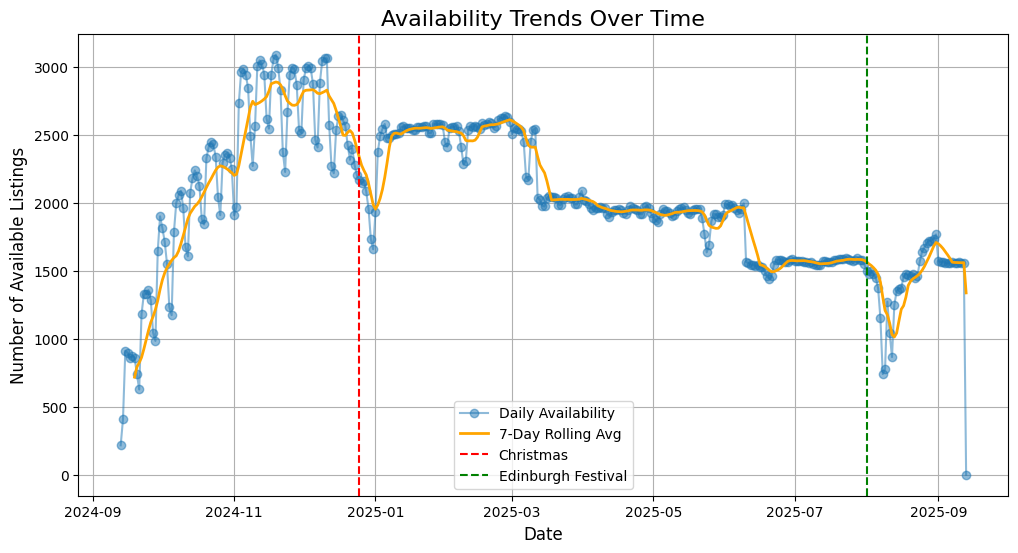

In [80]:
# Calculate availability counts by date
availability_by_date = calendar_df[calendar_df['available'] == 't'].groupby('date').size()

# Ensure the index is in datetime format
availability_by_date.index = pd.to_datetime(availability_by_date.index)

# Create a rolling average for smoother trends
rolling_avg = availability_by_date.rolling(window=7).mean()

# Define key events as Timestamps
christmas = pd.Timestamp('2024-12-25')
edinburgh_festival = pd.Timestamp('2025-08-01')

# Plot the data
plt.figure(figsize=(12, 6))

# Plot raw availability data
plt.plot(availability_by_date.index, availability_by_date, label="Daily Availability", marker='o', alpha=0.5)

# Plot rolling average
plt.plot(availability_by_date.index, rolling_avg, label="7-Day Rolling Avg", linewidth=2, color='orange')

# Highlight key events
plt.axvline(christmas, color='red', linestyle='--', label='Christmas')
plt.axvline(edinburgh_festival, color='green', linestyle='--', label='Edinburgh Festival')

# Add titles, labels, and legend
plt.title("Availability Trends Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Available Listings", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


- There is a steady rise in the number of available listings from September to late November 2024, peaking at around 3,000 listings in December. This trend could reflect increasing supply during the off-peak season when hosts list their properties to attract winter travelers.

- After December, availability stabilizes at around 2,500 listings, suggesting consistent supply during the colder months and early spring.

- There’s a clear drop in availability as summer approaches. This may indicate increased bookings due to higher demand during the peak travel season. Listings drop to around 1,500-2,000 in mid-summer.

- Several sharp dips and spikes are visible, likely caused by events (e.g., festivals or holidays), cancellations, or sudden demand changes.


##### **Potential Explanations:**

**Seasonality:**

- The rise in availability during Autumn/Winter aligns with the lower tourist season when fewer travelers visit Edinburgh.
- The decline in Summer aligns with peak travel periods like festivals and holidays.

**Local Events:**

- The Edinburgh International Festival (August).
- Christmas and New Year holidays (December-January).
- Smaller events or conferences.


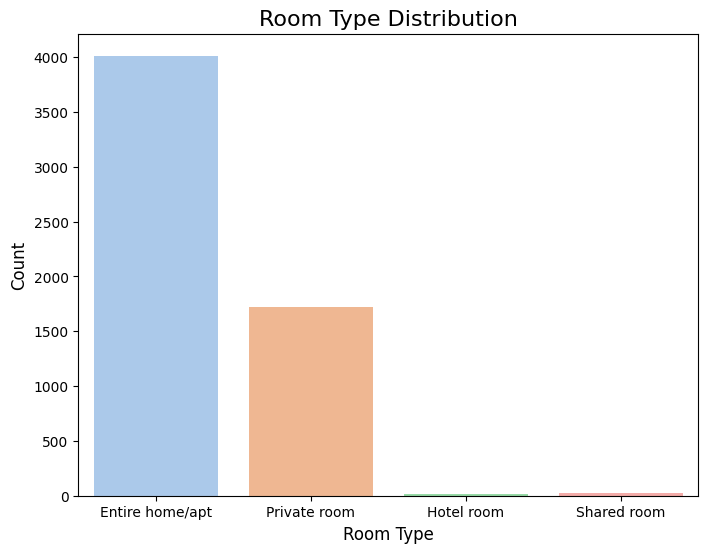

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=listings_df, x='room_type', hue='room_type', palette='pastel', legend=False)
plt.title("Room Type Distribution", fontsize=16)
plt.xlabel("Room Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

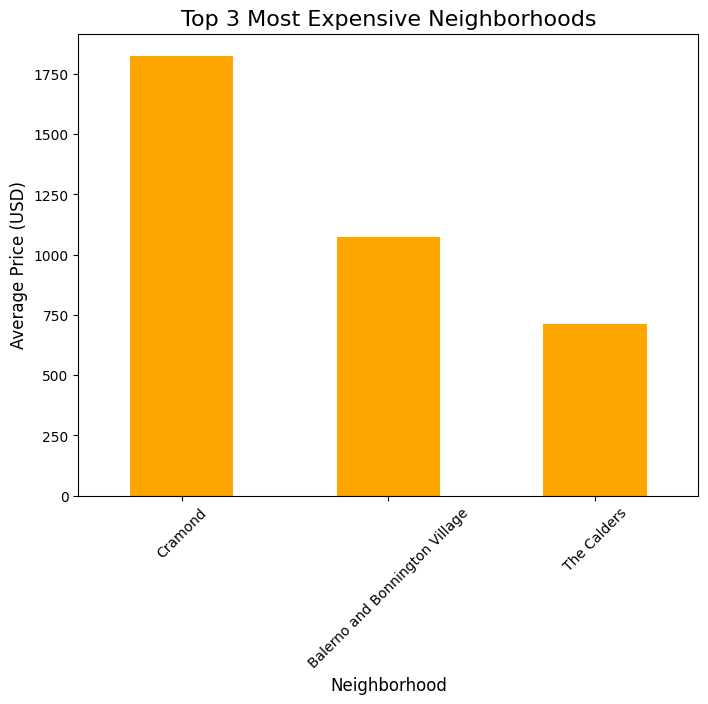

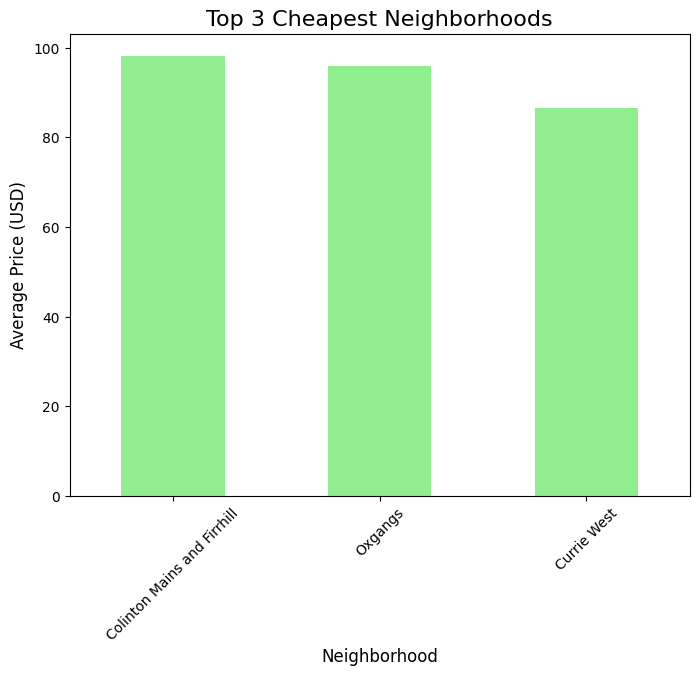

In [82]:
# Group by neighborhood and calculate average price
neighborhood_avg_price = s_listings_df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

# Select top 3 most expensive and top 3 cheapest neighborhoods
top_3_expensive = neighborhood_avg_price.head(3)
top_3_cheapest = neighborhood_avg_price.tail(3)

# Plot for Top 3 Most Expensive Neighborhoods
plt.figure(figsize=(8, 6))
top_3_expensive.plot(kind='bar', color='orange')
plt.title("Top 3 Most Expensive Neighborhoods", fontsize=16)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Plot for Top 3 Cheapest Neighborhoods
plt.figure(figsize=(8, 6))
top_3_cheapest.plot(kind='bar', color='lightgreen')
plt.title("Top 3 Cheapest Neighborhoods", fontsize=16)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.show()



#### **Step 6: Univariate Analysis**

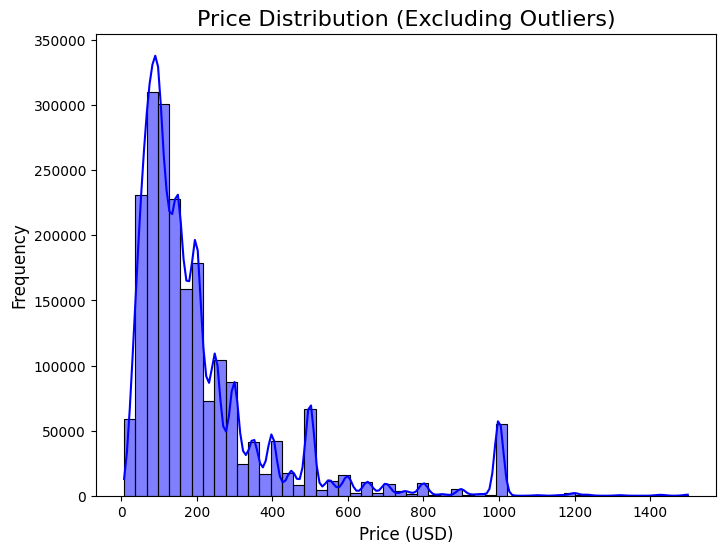

In [83]:
# Remove outliers
filtered_data = merged_data[merged_data['price_x'] < 1500]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(filtered_data['price_x'], bins=50, kde=True, color='blue')
plt.title("Price Distribution (Excluding Outliers)", fontsize=16)
plt.xlabel("Price (USD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

- The data is heavily skewed to the right, with the majority of listings priced below $500.
The tail of the distribution includes listings with very high prices, up to $10,000.

- A small number of listings have extreme prices, significantly higher than the majority.
These outliers may represent luxury properties or misreported prices.

- There is a sharp peak around $0 to $200, indicating that most listings are budget-friendly.

#### **Step 7: Bivariate Analysis**

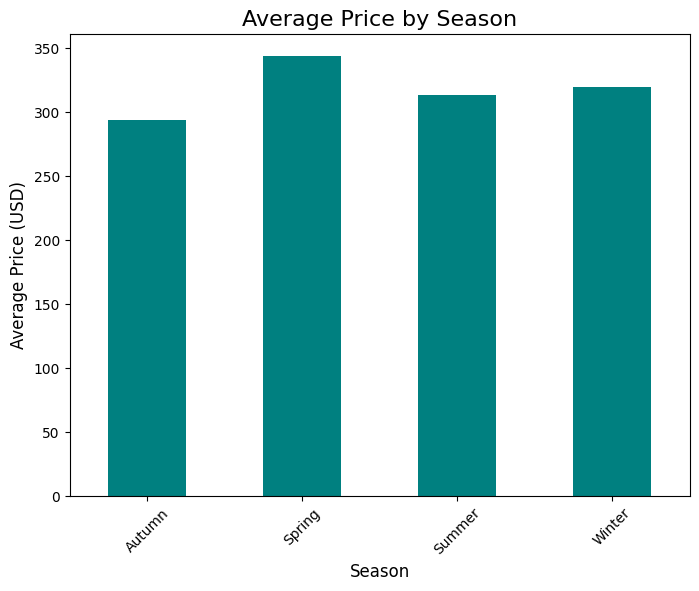

In [90]:
# Calculate average price per season
avg_price_season = merged_data[merged_data['available'] == True].groupby('season')['price_x'].mean()

# Plot average price per season
plt.figure(figsize=(8, 6))
avg_price_season.plot(kind='bar', color='teal')
plt.title("Average Price by Season", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.show()


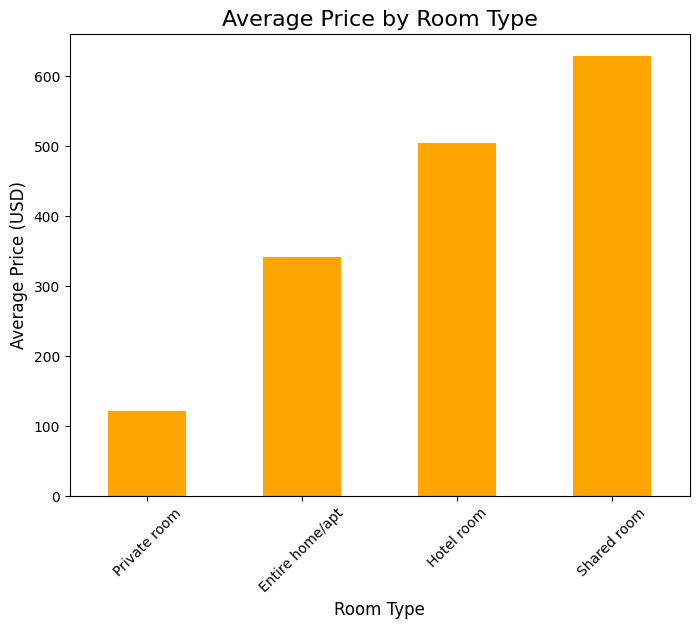

In [86]:
# Calculate average price by room type and sort in ascending order
avg_price_room_type = merged_data.groupby('room_type')['price_x'].mean().sort_values()

# Plot average price by room type
plt.figure(figsize=(8, 6))
avg_price_room_type.plot(kind='bar', color='orange')
plt.title("Average Price by Room Type", fontsize=16)
plt.xlabel("Room Type", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.show()


#### **Step 8: Multivariate Analysis**

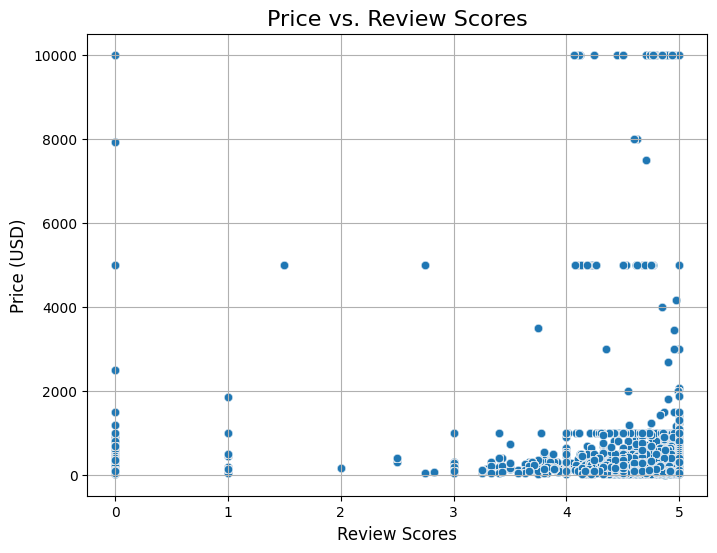

In [ ]:
# Scatter plot of price vs. review scores
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_data, x='review_scores_rating', y='price_x', alpha=0.6)
plt.title("Price vs. Review Scores", fontsize=16)
plt.xlabel("Review Scores", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.grid(True)
plt.show()

- There is a dense cluster of listings with review scores between 4.0 and 5.0 and prices below $500.
This suggests that the majority of listings are affordable and well-rated.

- There are a few outliers with prices above $2000. These outliers may represent luxury or niche accommodations, and their review scores are usually high ranging 4 and 5.

- Listings with review scores below 3.0 are sparse, indicating that most listings achieve moderate-to-high satisfaction.

- There doesn’t appear to be a strong linear or non-linear relationship between price and review scores.
Review scores seem to remain high across a wide price range.

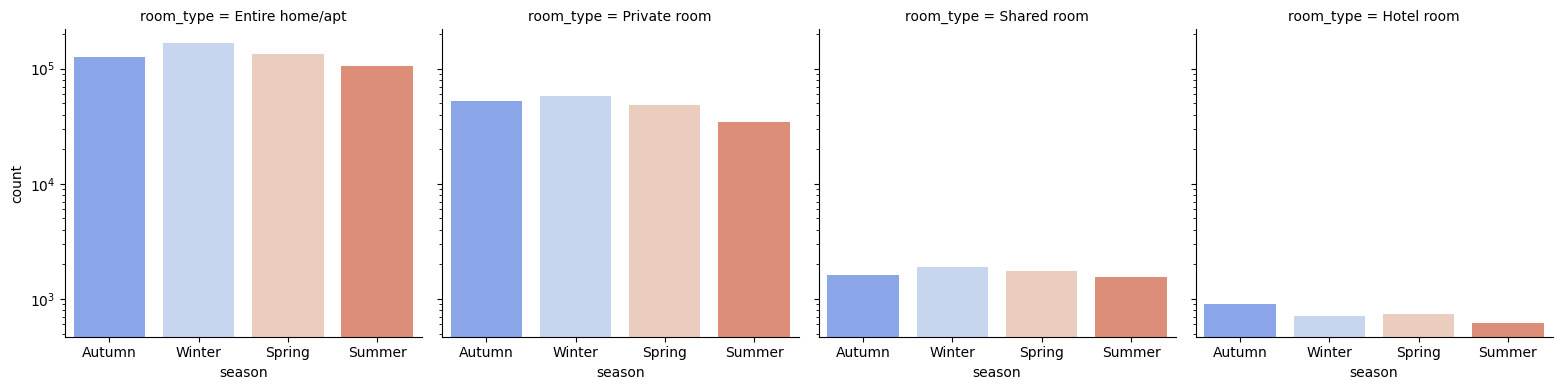

In [88]:
# Graph the count of available listings per season and room type
g = sns.catplot(
    data=merged_data[merged_data['available'] == True],
    x='season',
    hue='season',
    col='room_type',
    kind='count',
    height=4,
    aspect=1,
    palette='coolwarm',
    legend=False,
    sharey=True  # Keep shared y-axis
)

# Apply logarithmic scale to all y-axes
for ax in g.axes.flat:
    ax.set_yscale("log")  # Set y-axis to log scale

# Show the plot
plt.show()

- Winter has the highest availability for `Entire home/apt`, followed by Spring and Autumn.
This aligns with expectations as these types of accommodations are popular with travelers seeking privacy, especially during colder months.

- Availability of `Shared rooms` and `Hotel rooms` is almost negligible, regardless of season.

- Winter generally has higher availability across most room types. This might indicate lower demand during colder months, while Summer has the least availability, likely reflecting increased demand during peak travel season.


##### **Potential Actions:** 

- **Revenue Opportunities in Winter**:

    - With higher availability during Winter, strategies like dynamic pricing or promotional discounts could help boost bookings.
Focus marketing efforts on Winter travelers (e.g., budget-conscious tourists).

- **Room Type Targeting:**

    - "Entire home/apt" dominates availability, making it a key segment to optimize for pricing and promotion strategies.
"Private rooms" also contribute significantly and could cater to budget-conscious travelers.

- **Prepare for Summer Peak:**

    - As Summer has lower availability, consider premium pricing for properties that are still available.

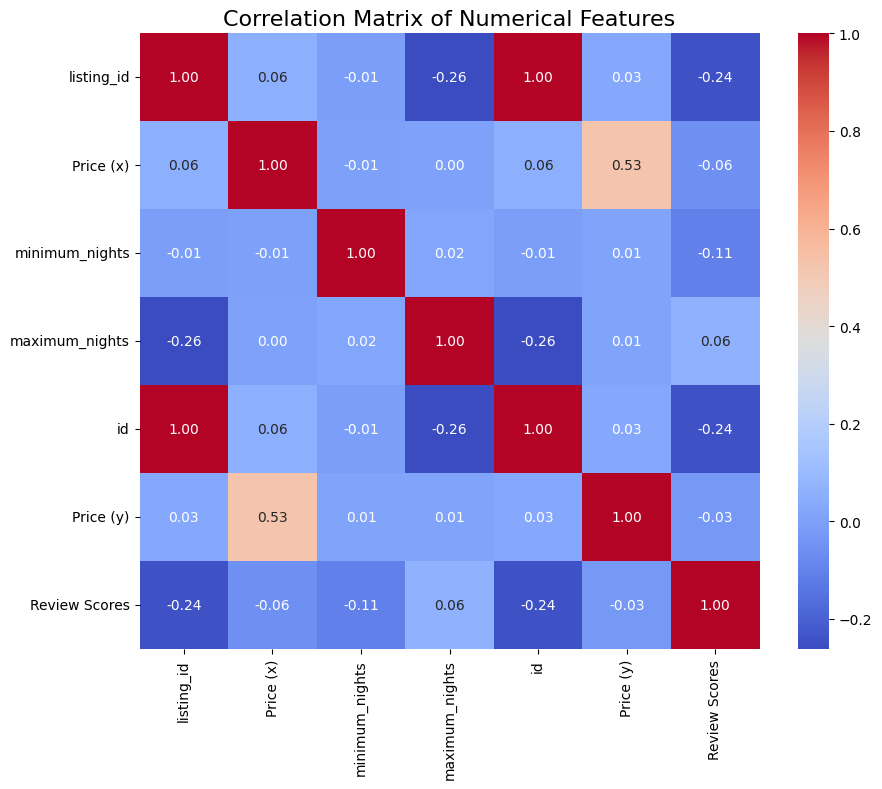

In [ ]:
# Select only numeric columns
numeric_data = merged_data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

correlation_matrix.rename(index={'price_x': 'Price (x)', 'price_y': 'Price (y)', 'review_scores_rating': 'Review Scores'},
                          columns={'price_x': 'Price (x)', 'price_y': 'Price (y)', 'review_scores_rating': 'Review Scores'}, inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 10})
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.show()

- `Price_x` and `Price_y` Have a High Positive Correlation (0.60):

    - Both represent price-related variables, likely reflecting similar patterns. This suggests they are redundant for modeling.

- Weak Correlation Between `review_scores_rating` and Price:

    - review_scores_rating has a weak negative correlation with price_x (-0.08) and price_y (-0.02).
This indicates that higher review scores do not strongly correlate with price. Pricing decisions might not be heavily influenced by guest ratings.

#### **Step 9: Review Analysis**

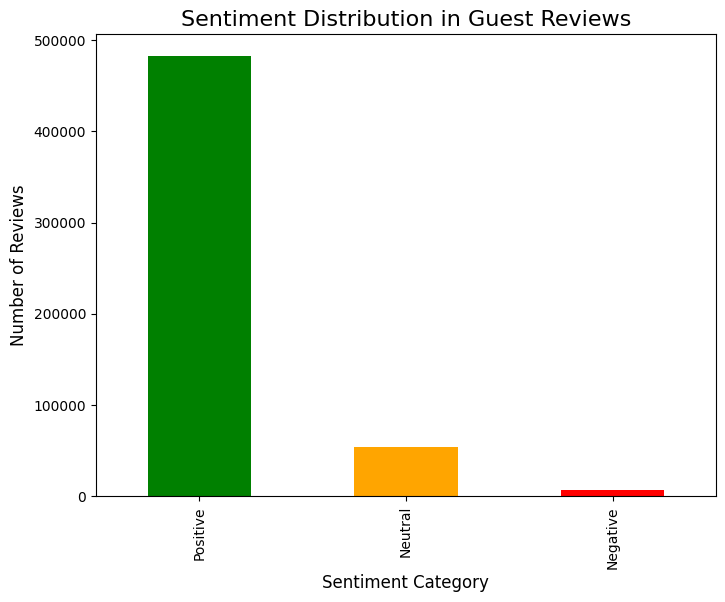

In [92]:
# Function to calculate sentiment polarity
def get_sentiment(comment):
    return TextBlob(comment).sentiment.polarity

# Apply sentiment analysis
reviews_df['sentiment'] = reviews_df['comments'].dropna().apply(get_sentiment)

# Categorize sentiments as Positive, Negative, or Neutral
reviews_df['sentiment_category'] = reviews_df['sentiment'].apply(
    lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral'
)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
reviews_df['sentiment_category'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Sentiment Distribution in Guest Reviews", fontsize=16)
plt.xlabel("Sentiment Category", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.show()

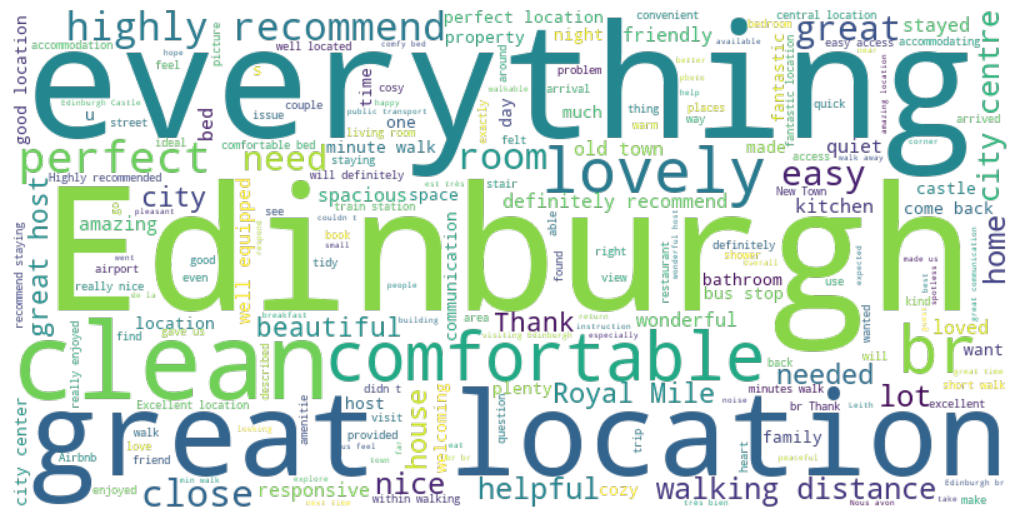

In [ ]:
# Combine all review comments into a single string
all_reviews = " ".join(reviews_df['comments'].dropna().astype(str))

# Set up stopwords to exclude common words and additional words
additional_stopwords = {'stay', 'apartment', 'flat', 'place', 'check'}
stopwords = set(STOPWORDS).union(additional_stopwords)

# Filter out words with less than 2 letters
filtered_reviews = " ".join([word for word in all_reviews.split() if len(word) > 1])

# Generate the word cloud with a transparent background
wordcloud_transparent = WordCloud(
    width=800,
    height=400,
    mode='RGBA',  # Supports transparency
    background_color=None,  # Transparent background
    stopwords=stopwords,
    colormap='viridis'
).generate(filtered_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_transparent, interpolation='bilinear')
plt.axis('off')  # Removes the white frame
plt.tight_layout(pad=0)  # Removes extra padding
plt.savefig("wordcloud_transparent.png", dpi=300, format='png', bbox_inches='tight', transparent=True)  # Save with transparency
plt.show()


- **Positive Sentiment:**

    - Words like "great," "clean," "comfortable," "lovely," "perfect," "helpful," and "beautiful" suggest that guests frequently use positive adjectives to describe their experiences. This indicates a high level of guest satisfaction in many cases.

- **Location Matters:**

    - Words like "Edinburgh," "location," "city centre," "Royal Mile," "walking distance," and "close" emphasize that the location of listings is a critical factor in guest reviews. Proximity to key attractions like the **Royal Mile** and city center is a recurring theme.

- **Amenities and Features:**

    - Guests mention terms like "clean," "spacious," "comfortable," "kitchen," and "bedroom", which highlight the importance of cleanliness and functional amenities in guest satisfaction.

- **Host Interaction:**

    - Words like "helpful," "responsive," "kind," and "friendly" indicate that hosts' behavior and communication play a significant role in shaping guests' perceptions.

- **Recommendations:**

    - Terms like "highly recommend" and "recommend" are prominent, which suggests that many guests are satisfied enough to recommend the listings to others.

##### **What This Tells Us**

**Strengths of Listings:**

- Guests value cleanliness, comfort, and great locations. Listings with these attributes are more likely to receive positive reviews.
- Hosts who are helpful and responsive contribute significantly to positive experiences.

**Key Selling Points:**

- Highlighting proximity to key landmarks (e.g., the Royal Mile, city center) and emphasizing amenities like cleanliness and comfort can attract more guests.

**Strategic Marketing:**

- Use terms like "great location," "clean," "comfortable," and "walking distance" in listing descriptions to align with what guests value most.


In [94]:
# Calculate sentiment polarity
reviews_df['sentiment'] = reviews_df['comments'].dropna().apply(lambda x: TextBlob(x).sentiment.polarity)

In [96]:
# Ensure the 'date' column is in datetime format
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

# Group by date and calculate average sentiment
sentiment_trend = reviews_df.groupby(reviews_df['date'].dt.to_period('M'))['sentiment'].mean()

# Convert period index to datetime for plotting
sentiment_trend.index = sentiment_trend.index.to_timestamp()

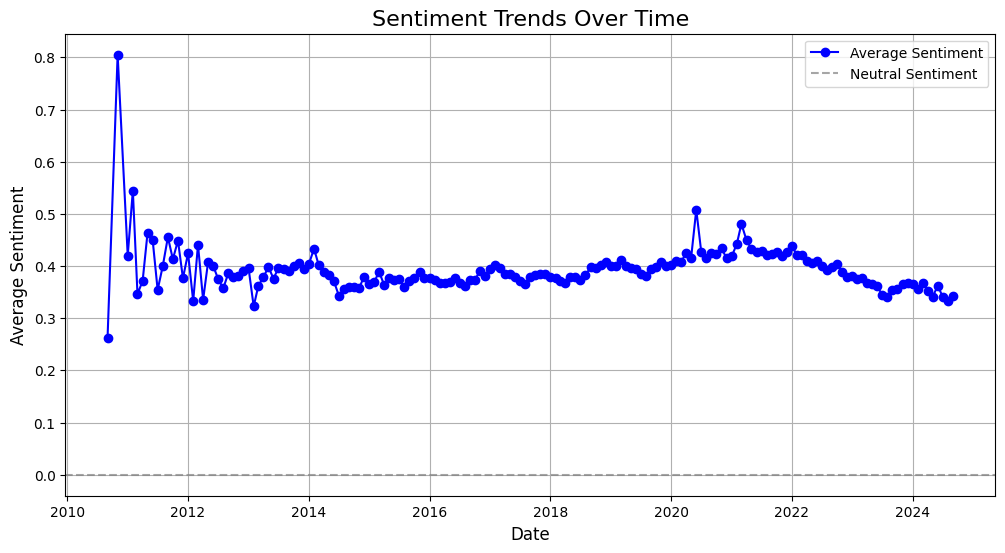

In [ ]:
# Plot sentiment trends
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend.index, sentiment_trend, marker='o', color='blue', label='Average Sentiment')
plt.axhline(0, color='gray', linestyle='--', alpha=0.7, label='Neutral Sentiment')
plt.title("Sentiment Trends Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

##### **Geographic Group Analysis:** 

In [ ]:
# Merge reviews_df with listings_df to include neighborhood information
reviews_with_neighborhood = reviews_df.merge(
    listings_df[['id', 'neighbourhood_cleansed']], 
    left_on='listing_id', 
    right_on='id', 
    how='left'
)

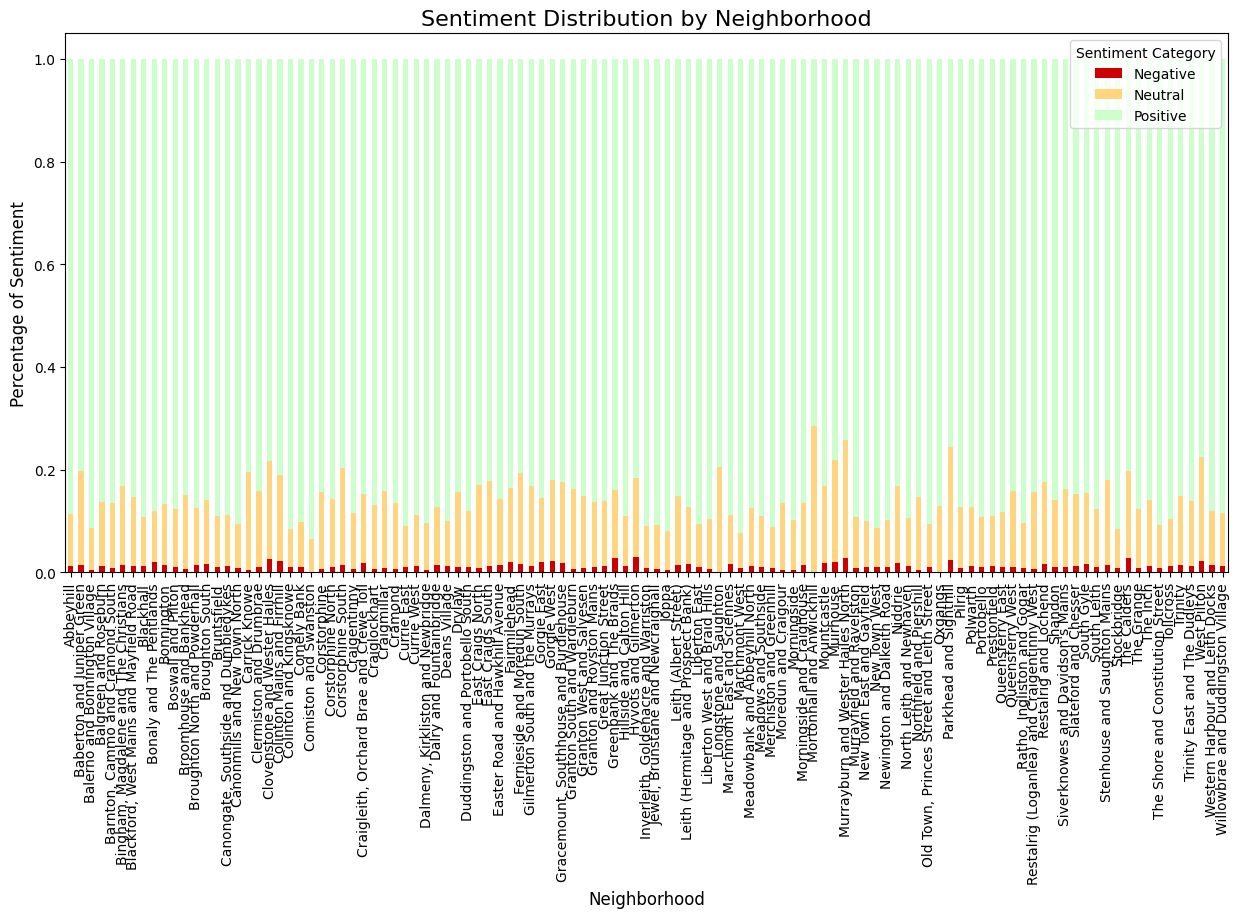

In [ ]:
# Group sentiment categories by neighborhood
sentiment_distribution = reviews_with_neighborhood.groupby(['neighbourhood_cleansed', 'sentiment_category']).size().unstack(fill_value=0)

# Normalize to show percentages (relative distribution within each neighborhood)
sentiment_distribution = sentiment_distribution.div(sentiment_distribution.sum(axis=1), axis=0)

# Define colors
colors = {'Negative': '#CC0000', 'Neutral': '#FFD580', 'Positive': '#CCFFCC'}

# Plot sentiment distribution as a stacked bar chart
ax = sentiment_distribution.plot(kind='bar', stacked=True, figsize=(15, 7), color=[colors[col] for col in sentiment_distribution.columns])
plt.title("Sentiment Distribution by Neighborhood", fontsize=16)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("Percentage of Sentiment", fontsize=12)

plt.gca().margins(x=0.01)  # Add space between x-axis labels
plt.legend(title="Sentiment Category", loc="upper right")
plt.show()

- Neighborhoods such as Mortonhall and Anwickhill, and Murrayburn and Western Hailes North show relatively higher levels of neutral sentiment compared to others. Neutral reviews may reflect a lack of standout experiences or balanced feedback.

- A few neighborhoods stand out with a relatively higher proportion of neutral sentiment:
    - Old Town and New Town (likely due to high expectations in the City Centre).
    - Some East and South neighborhoods also show slightly elevated neutral reviews.

- The neighborhoods with higher neutral sentiment (e.g., Old Town, New Town) may indicate areas where guest expectations are higher. Listings in these areas might need to focus on exceeding expectations to stand out.

##### **Recommendations:**

- For neighborhoods with higher neutral reviews, hosts can:

    - Improve guest engagement by providing personalized touches.
    - Highlight unique aspects of their property or location to make the experience more memorable.
    - Consider guest feedback in these areas to identify specific issues (e.g., noise, cost, or crowding) that might be leading to "average" experiences.

- Highlight Positive Neighborhoods:

    - Promote neighborhoods with consistently high positive sentiment in marketing campaigns.



In [ ]:
neighborhood_mapping = {
    # City Centre
    'Old Town': 'City Centre',
    'New Town': 'City Centre',
    'West End': 'City Centre',
    'Haymarket': 'City Centre',
    'Broughton and York Place': 'City Centre',
    'Canongate, Southside and Dumbiedykes': 'City Centre',
    'Canonmills and New Town North': 'City Centre',
    'Old Town, Princes Street and Leith Street': 'City Centre',
    'New Town East and Gayfield': 'City Centre',
    'New Town West': 'City Centre',
    'Dalry and Fountainbridge': 'City Centre',
    'Hillside and Calton Hill': 'City Centre',
    'Tollcross': 'City Centre',

    # North-East
    'Leith': 'North-East',
    'Newhaven': 'North-East',
    'The Shore and Constitution Street': 'North-East',
    'Easter Road and Abbeyhill': 'North-East',
    'Piershill and Lochend': 'North-East',
    'Craigentinny and Meadowbank': 'North-East',
    'Restalrig (Loganlea)': 'North-East',
    'Abbeyhill': 'North-East',
    'Broughton North and Powderhall': 'North-East',
    'Meadowbank and Abbeyhill North': 'North-East',
    'Restalrig (Loganlea) and Craigentinny West': 'North-East',
    'Restalrig and Lochend': 'North-East',
    'Craigentinny': 'North-East',
    'Northfield and Piershill': 'North-East',
    'Duddingston and Portobello South': 'North-East',
    'Great Junction Street': 'North-East',
    'Leith (Albert Street)': 'North-East',
    'Leith (Hermitage and Prospect Bank)': 'North-East',
    'South Leith': 'North-East',
    'Western Harbour and Leith Docks': 'North-East',
    'North Leith and Newhaven': 'North-East',

    # North-West
    'Trinity': 'North-West',
    'Granton': 'North-West',
    'Silverknowes and Cramond': 'North-West',
    'Craigleith, Orchard Brae, and Drylaw': 'North-West',
    'East Craigs and Maybury': 'North-West',
    'Granton South and Wardieburn': 'North-West',
    'Granton West and Salvesen': 'North-West',
    'Granton and Royston Mains': 'North-West',
    'Trinity East and The Dudleys': 'North-West',
    'Muirhouse': 'North-West',
    'Boswall and Pilton': 'North-West',
    'West Pilton': 'North-West',
    'Silverknowes and Davidson’s Mains': 'North-West',
    'Cramond': 'North-West',
    'Barnton, Cammo and Cramond South': 'North-West',
    'Clermiston and Drumbrae': 'North-West',
    'Drylaw': 'North-West',
    'East Craigs North': 'North-West',
    'East Craigs South': 'North-West',

    # South-East
    'Morningside and Bruntsfield': 'South-East',  
    'Grange and Blackford': 'South-East',  
    'Craigmillar and Niddrie': 'South-East',
    'Gilmerton and Mortonhall': 'South-East',
    'Duddingston and Joppa': 'South-East',
    'Craigmillar': 'South-East',
    'Niddrie': 'South-East',
    'Bingham, Magdalene and The Christians': 'South-East',
    'Duddingston and Portobello South': 'South-East',
    'Mortonhall and Anwickhill': 'South-East',
    'Hyvots and Gilmerton': 'South-East',
    'Liberton East': 'South-East',
    'Liberton West and Braid Hills': 'South-East',
    'Prestonfield': 'South-East',
    'Fernieside and Moredun South': 'South-East',
    'Moredun and Craigour': 'South-East',
    'Gracemount, Southhouse and Burdiehouse': 'South-East',  

    # South-West
    'Liberton and Southhouse': 'South-West',  
    'Gracemount, Southhouse, and Burdiehouse': 'South-West',
    'Baberton and Juniper Green': 'South-West',
    'Currie and Balerno': 'South-West',
    'Ratho and Newbridge': 'South-West',
    'Wester Hailes': 'South-West',
    'Sighthill and Calders': 'South-West',
    'Bonaly and Colinton': 'South-West',
    'Colinton Mains and Firrhill': 'South-West',
    'Colinton and Kingsknowe': 'South-West',
    'Bonaly and The Pentlands': 'South-West',
    'Currie East': 'South-West',
    'Currie West': 'South-West',
    'Balerno and Bonnington Village': 'South-West',
    'Ratho, Ingliston and Gogar': 'South-West',
    'Clovenstone and Wester Hailes': 'South-West',
    'Murrayburn and Wester Hailes North': 'South-West',
    'Baberton and Juniper Green': 'South-West',
    'The Calders': 'South-West',

    # West
    'Corstorphine': 'West',
    'Murrayfield': 'West',
    'South Gyle': 'West',
    'Corstorphine North': 'West',
    'Corstorphine South': 'West',
    'Murrayfield and Ravelston': 'West',
    'Longstone and Saughton': 'West',
    'Slateford and Chesser': 'West',
    'Stenhouse and Saughton Mains': 'West',
    'Parkhead and Sighthill': 'West',
    'Gorgie East': 'West',
    'Gorgie West': 'West',

    # East
    'Portobello': 'East',
    'Joppa': 'East',
    'Duddingston and Portobello South': 'East',
    'Willowbrae and Duddingston Village': 'East',
    'Mountcastle': 'East',
    'Jewel, Brunstane and Newcraighall': 'East',


    # Other
    'Trinity East and the Botanic Gardens': 'Other',
    'Dalry and Fountainbridge': 'Other',
    'Broughton South': 'Other',
    'Stockbridge': 'Other',
    'Comely Bank': 'Other',
    'Blackhall': 'Other',
    'Greenbank and The Braids': 'Other',
    'Fairmilehead': 'Other',
    'Marchmont East and Sciennes': 'Other',
    'Marchmont West': 'Other',
    'Morningside': 'Other',
    'Morningside and Craighouse': 'Other',
    'Merchiston and Greenhill': 'Other',
    'Comiston and Swanston': 'Other',
    'The Grange': 'Other',
    'Polwarth': 'Other',
    'Shandon': 'Other',
    'Deans Village': 'Other', 
}

In [ ]:
# Assign geographic groups to neighborhoods using the updated mapping
reviews_with_neighborhood['geo_group'] = reviews_with_neighborhood['neighbourhood_cleansed'].apply(
    lambda x: neighborhood_mapping.get(x, 'Other')  # Default to 'Other' if not found in mapping
)

In [159]:
reviews_with_neighborhood.head()

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,cleaned_comments,sentiment,sentiment_category,id_y,neighbourhood_cleansed,geo_group,price
0,15420,171793,2011-01-18,186358,Nels,My wife and I stayed at this beautiful apartme...,my wife and i stayed at this beautiful apartme...,0.351488,Positive,15420,"Old Town, Princes Street and Leith Street",City Centre,145.0
1,15420,176350,2011-01-31,95218,Gareth,Charlotte couldn't have been a more thoughtful...,charlotte couldn't have been a more thoughtful...,0.385714,Positive,15420,"Old Town, Princes Street and Leith Street",City Centre,145.0
2,15420,232149,2011-04-19,429751,Guido,I went to Edinburgh for the second time on Apr...,i went to edinburgh for the second time on apr...,0.260787,Positive,15420,"Old Town, Princes Street and Leith Street",City Centre,145.0
3,15420,236073,2011-04-23,420830,Mariah,This flat was incredible. As other guests have...,this flat was incredible. as other guests have...,0.358929,Positive,15420,"Old Town, Princes Street and Leith Street",City Centre,145.0
4,15420,263713,2011-05-15,203827,Linda,Fantastic host and the apartment was perfect. ...,fantastic host and the apartment was perfect. ...,0.448889,Positive,15420,"Old Town, Princes Street and Leith Street",City Centre,145.0


In [130]:
# Group sentiment by geographic group and sentiment category
geo_sentiment_distribution = reviews_with_neighborhood.groupby(['geo_group', 'sentiment_category']).size().unstack(fill_value=0)

# Normalize to percentages
geo_sentiment_distribution = geo_sentiment_distribution.div(geo_sentiment_distribution.sum(axis=1), axis=0)

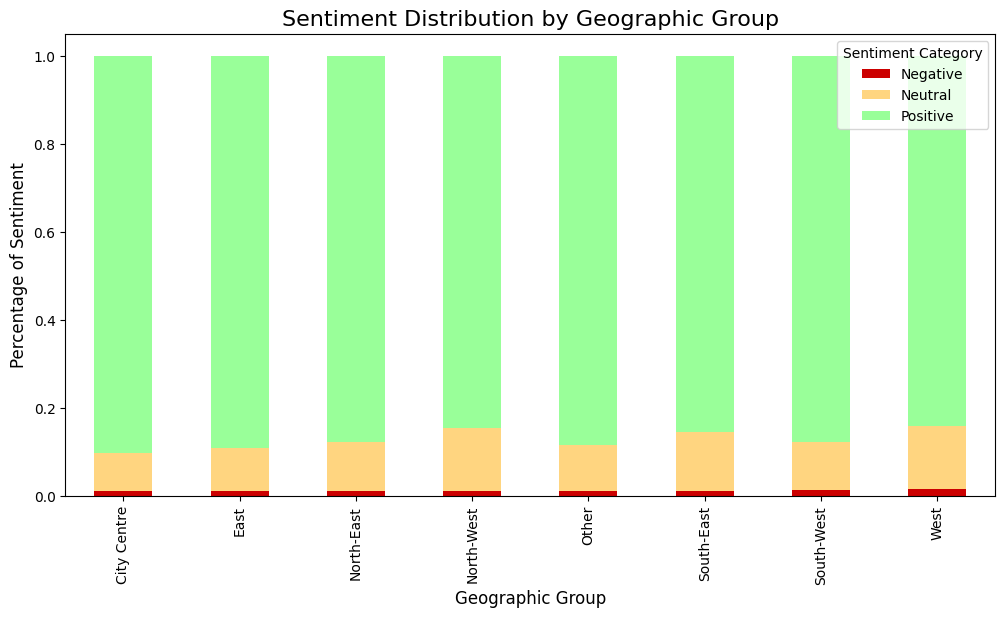

In [ ]:
# Plot sentiment distribution by geographic group
colors = {'Negative': '#CC0000', 'Neutral': '#FFD580', 'Positive': '#99FF99'}
geo_sentiment_distribution.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors[col] for col in geo_sentiment_distribution.columns])
plt.title("Sentiment Distribution by Geographic Group", fontsize=16)
plt.xlabel("Geographic Group", fontsize=12)
plt.ylabel("Percentage of Sentiment", fontsize=12)
plt.legend(title="Sentiment Category", loc="upper right")
plt.show()

In [ ]:
# Apply the geographic group mapping to the listings_df
listings_df['geo_group'] = listings_df['neighbourhood_cleansed'].apply(
    lambda x: neighborhood_mapping.get(x, 'Other')  # Use the mapping dictionary defined earlier
)

In [118]:
reviews_with_neighborhood = reviews_df.merge(
    listings_df[['id', 'neighbourhood_cleansed', 'geo_group', 'price']],
    left_on='listing_id',
    right_on='id',
    how='left'
)

In [ ]:
# Calculate average price by geographic group
avg_price_by_geo = reviews_with_neighborhood.groupby('geo_group')['price'].mean().sort_values(ascending=False)

# Print or inspect the result
print(avg_price_by_geo)

geo_group
City Centre    210.151270
Other          167.143990
North-West     158.459907
North-East     155.308566
South-West     154.973036
South-East     152.941968
East           145.515763
West           130.894489
Name: price, dtype: float64


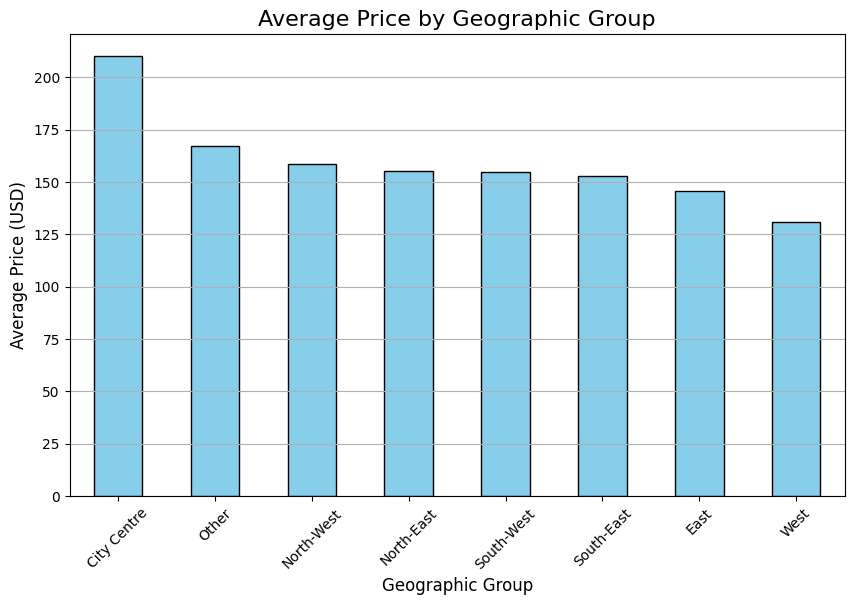

In [ ]:
# Plot average prices by geographic group
plt.figure(figsize=(10, 6))
avg_price_by_geo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Price by Geographic Group", fontsize=16)
plt.xlabel("Geographic Group", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
# Calculate the proportion of positive sentiment by geographic group
positive_sentiment_ratio = reviews_with_neighborhood[reviews_with_neighborhood['sentiment_category'] == 'Positive'].groupby('geo_group').size() / reviews_with_neighborhood.groupby('geo_group').size()

# Combine average price and positive sentiment ratio
geo_price_sentiment = pd.DataFrame({
    'Average Price (USD)': avg_price_by_geo,
    'Positive Sentiment Ratio': positive_sentiment_ratio
}).sort_values(by='Average Price (USD)', ascending=False)

print(geo_price_sentiment)

             Average Price (USD)  Positive Sentiment Ratio
geo_group                                                 
City Centre           210.151270                  0.901719
Other                 167.143990                  0.885180
North-West            158.459907                  0.845465
North-East            155.308566                  0.876909
South-West            154.973036                  0.877446
South-East            152.941968                  0.855153
East                  145.515763                  0.890338
West                  130.894489                  0.839949


In [ ]:
# Create a Plotly scatter plot
fig = px.scatter(
    geo_price_sentiment,
    x='Positive Sentiment Ratio',
    y='Average Price (USD)',
    text=geo_price_sentiment.index,  # This will display names on hover
    color=geo_price_sentiment.index,  # Use geographic group names for color
    color_discrete_map=colors,
    labels={
        'Positive Sentiment Ratio': 'Positive Sentiment Ratio',
        'Average Price (USD)': 'Average Price (USD)'
    },
    title="Correlation Between Positive Sentiment and Average Price",
    hover_data={
        'Positive Sentiment Ratio': True,
        'Average Price (USD)': True,
    }
)

# Customize marker size and layout
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='black')), textposition='top center')

# Update legend title
fig.update_layout(legend_title_text='Geographical Groups')
fig.show()


- The City Centre group has the highest average price (~$210) despite having only a moderate positive sentiment ratio (~0.86).
This suggests that location plays a significant role in pricing, with proximity to central attractions driving prices regardless of sentiment.

- East and North-East regions exhibit the highest positive sentiment ratios (~0.89) among all groups.
Despite this, their average prices are significantly lower (~$160–$180) compared to the City Centre. This suggests that these regions provide good value for money in terms of guest experience.

- The Other category has moderate pricing (~$180) and sentiment (~0.88).
This indicates that "Other" neighborhoods might include a mix of less central but reasonably popular areas.


In [ ]:
# Calculate positive sentiment ratio and average price per neighborhood
neighborhood_stats = reviews_with_neighborhood.groupby(['neighbourhood_cleansed', 'geo_group']).agg(
    average_price=('price', 'mean'),
    positive_sentiment_ratio=('sentiment_category', lambda x: (x == 'Positive').sum() / len(x))
).reset_index()

print(neighborhood_stats.head())

             neighbourhood_cleansed   geo_group  average_price  \
0                         Abbeyhill  North-East     169.163877   
1        Baberton and Juniper Green  South-West      88.006006   
2    Balerno and Bonnington Village  South-West     286.674897   
3             Balgreen and Roseburn       Other     127.456017   
4  Barnton, Cammo and Cramond South  North-West      95.372881   

   positive_sentiment_ratio  
0                  0.887298  
1                  0.801802  
2                  0.913580  
3                  0.862960  
4                  0.864407  


In [138]:
# Define a color mapping for geographic groups
geo_color_mapping = {
    'City Centre': 'blue',
    'North-East': 'green',
    'North-West': 'orange',
    'South-East': 'purple',
    'South-West': 'red',
    'East': 'cyan',
    'West': 'brown',
    'Other': 'gray'
}

# Map geographic groups to colors
neighborhood_stats['color'] = neighborhood_stats['geo_group'].map(geo_color_mapping)


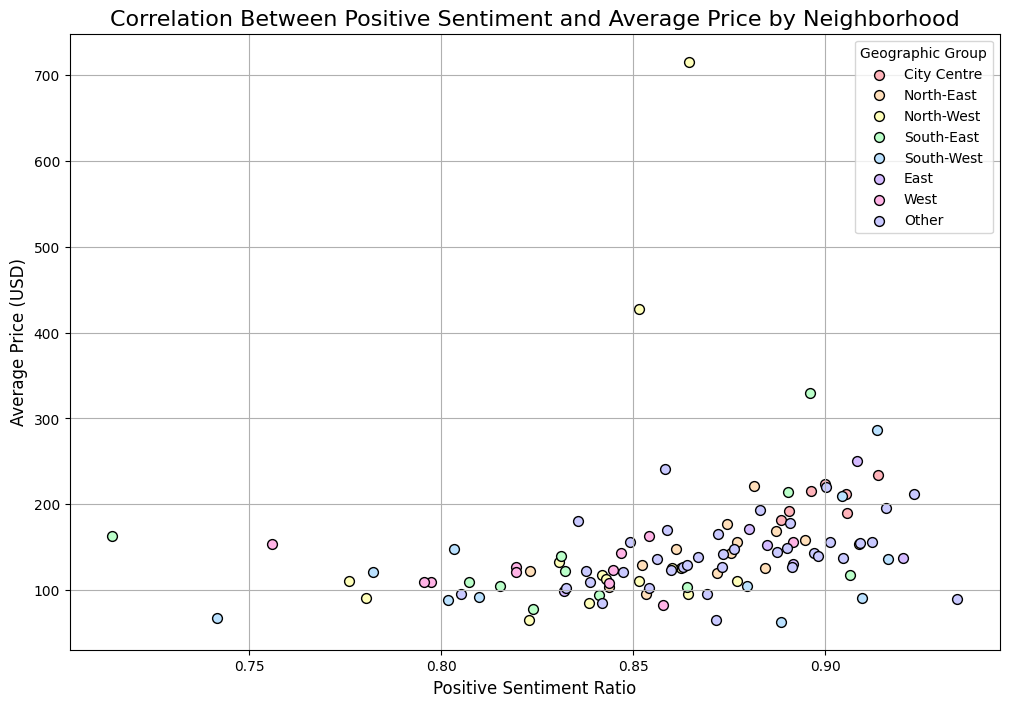

In [ ]:
# Define a pastel color palette
pastel_colors = {
    'City Centre': '#FFB3BA',
    'North-East': '#FFDFBA',
    'North-West': '#FFFFBA',
    'South-East': '#BAFFC9',
    'South-West': '#BAE1FF',
    'East': '#D4BAFF',
    'West': '#FFB3E6',
    'Other': '#C9C9FF'
}

# Scatter plot for all neighborhoods
plt.figure(figsize=(12, 8))
for group, color in pastel_colors.items():
    subset = neighborhood_stats[neighborhood_stats['geo_group'] == group]
    plt.scatter(subset['positive_sentiment_ratio'], subset['average_price'], color=color, label=group, edgecolor='black', s=50)
plt.title("Correlation Between Positive Sentiment and Average Price by Neighborhood", fontsize=16)
plt.xlabel("Positive Sentiment Ratio", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.legend(title="Geographic Group", fontsize=10)
plt.grid(True)
plt.show()


##### **Recommendations:**

- Leverage City Center's high prices and central location but focus on improving sentiment through better property quality or enhanced guest experiences.

- Market East and North-East regions as cost-effective alternatives to the City Centre with strong guest satisfaction.

- Address guest concerns in West and South-West to improve sentiment. This could involve offering additional amenities or enhancing customer service.

- Further analyze neighborhoods in the Other group to identify hidden opportunities or challenges.

#### **Step 10: Revenue Drivers**

In [ ]:
# Calculate occupancy rate from calendar data
calendar_df['is_booked'] = calendar_df['available'].apply(lambda x: 0 if x == 't' else 1)
occupancy = calendar_df.groupby('listing_id')['is_booked'].mean()

# Merge occupancy into listings data
listings_with_occupancy = listings_df.merge(occupancy, left_on='id', right_index=True)
listings_with_occupancy.rename(columns={'is_booked': 'occupancy_rate'}, inplace=True)

In [161]:
# Estimate revenue as price * occupancy rate * 365 (assuming yearly revenue)
listings_with_occupancy['estimated_revenue'] = (
    listings_with_occupancy['price'] *
    listings_with_occupancy['occupancy_rate'] *
    365
)

# Ensure the number of reviews column is included
listings_with_occupancy = listings_with_occupancy[['id', 'price', 'occupancy_rate', 'estimated_revenue', 'number_of_reviews']]


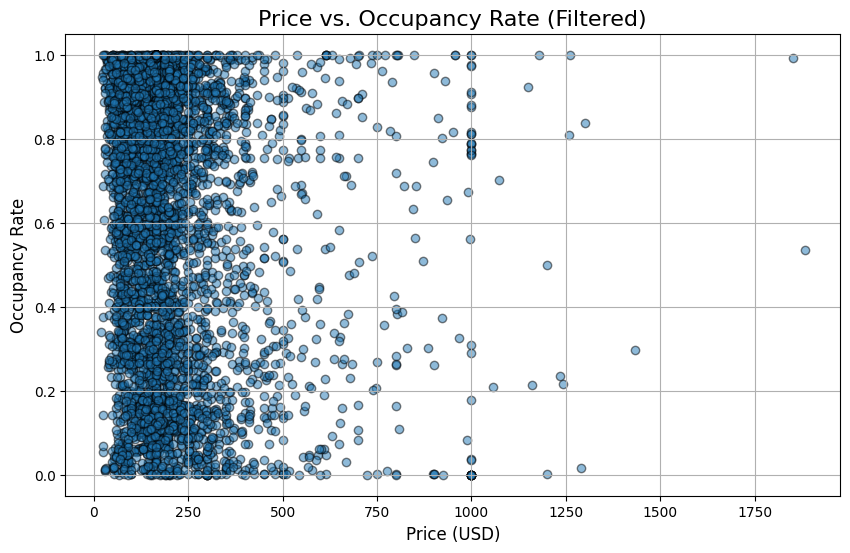

In [ ]:
# Remove outliers for better readability
filtered_data = listings_with_occupancy[listings_with_occupancy['price'] < 2000]

# Re-plot after filtering
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['price'], filtered_data['occupancy_rate'], alpha=0.5, edgecolor='black')
plt.title("Price vs. Occupancy Rate (Filtered)", fontsize=16)
plt.xlabel("Price (USD)", fontsize=12)
plt.ylabel("Occupancy Rate", fontsize=12)
plt.grid(True)
plt.show()

- Listings priced below $250 attract budget-conscious travelers or guests prioritizing affordability.

- Listings in the mid-range property range may need to focus on improving amenities, marketing, or reviews to stand out and maintain consistent bookings.

- High-priced listings above $1000 cater to a smaller audience, resulting in lower occupancy but potentially higher revenue per booking.

- Hosts often set prices at round numbers (e.g., $100, $200). This may reflect pricing psychology or default rates.

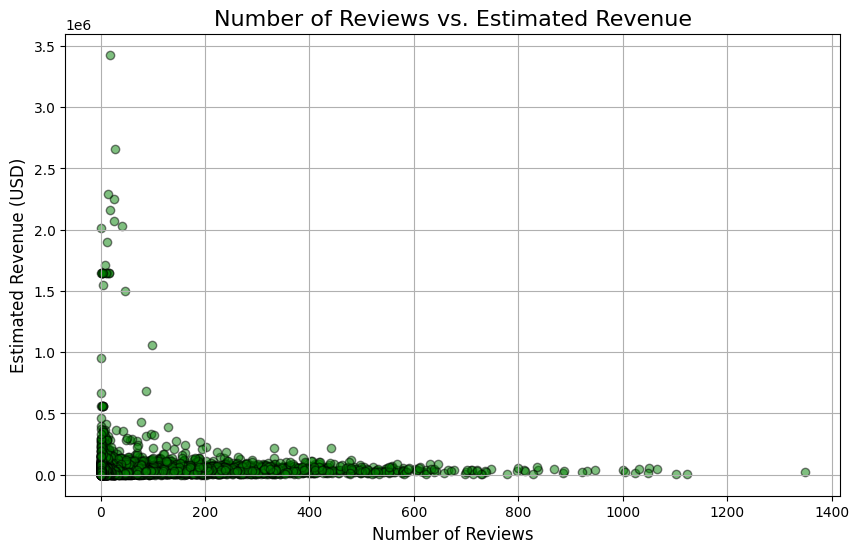

In [ ]:
# Scatter plot for number of reviews vs. estimated revenue
plt.figure(figsize=(10, 6))
plt.scatter(listings_with_occupancy['number_of_reviews'], listings_with_occupancy['estimated_revenue'], alpha=0.5, color='green', edgecolor='black')
plt.title("Number of Reviews vs. Estimated Revenue", fontsize=16)
plt.xlabel("Number of Reviews", fontsize=12)
plt.ylabel("Estimated Revenue (USD)", fontsize=12)
plt.grid(True)
plt.show()

- Listings with fewer reviews but high revenue suggest that pricing strategy or property type (e.g., luxury homes) can drive revenue even with limited guest feedback.

- Listings with more reviews may rely on high booking volume rather than high pricing. This trade-off might indicate a different market segment (e.g., budget travelers).

##### **Recommendations:**

- Listings with prices between $300 and $750 should explore price adjustments or added value (e.g., better amenities or services) to maintain competitiveness and improve occupancy.

- High-priced listings should focus on targeted marketing and highlighting unique features to appeal to niche audiences.



## **Phase 4: Advanced Analyses:**

#### **Step 11: A/B Testing**

In [175]:
# Merge `host_is_superhost` from listings_df into listings_with_occupancy
listings_with_occupancy = listings_with_occupancy.merge(
    listings_df[['id', 'host_is_superhost']],
    left_on='id',  # Adjust if the column is named differently in listings_with_occupancy
    right_on='id',
    how='left'
)

In [ ]:
# Filter data for superhost and non-superhost groups
non_superhost_data = listings_with_occupancy[listings_with_occupancy['host_is_superhost'] == 'f']
superhost_data = listings_with_occupancy[listings_with_occupancy['host_is_superhost'] == 't']

# Extract occupancy rates for the two groups
group_A = non_superhost_data['occupancy_rate']
group_B = superhost_data['occupancy_rate']

In [177]:
print(f"Number of Non-Superhosts: {len(non_superhost_data)}")
print(f"Number of Superhosts: {len(superhost_data)}")

Number of Non-Superhosts: 3175
Number of Superhosts: 2457


In [ ]:
def ab_testing(group_A, group_B, test_name=""):
    """
    Perform A/B testing with the appropriate statistical tests based on normality and variance checks.
    Parameters:
        group_A (pd.Series or list): Data for Group A.
        group_B (pd.Series or list): Data for Group B.
        test_name (str): A descriptive name for the test (e.g., "Superhost vs Non-Superhost").
    """
    print(f"Starting A/B Testing for: {test_name}\n")
    
    # Step 1: Test Normality
    print("Step 1: Testing Normality using Shapiro-Wilk Test")
    stat_A, p_A = shapiro(group_A)
    stat_B, p_B = shapiro(group_B)
    print(f"Group A: Statistic={stat_A:.4f}, p-value={p_A:.4f}")
    print(f"Group B: Statistic={stat_B:.4f}, p-value={p_B:.4f}")
    
    if p_A > 0.05 and p_B > 0.05:
        print("Both groups are normally distributed (p > 0.05). Proceeding to variance testing.\n")
        normal = True
    else:
        print("At least one group is not normally distributed (p <= 0.05). Proceeding with non-parametric tests.\n")
        normal = False

    # Step 2: Test Variance Equality
    if normal:
        print("Step 2: Testing Variance Equality using Levene's Test")
        stat_var, p_var = levene(group_A, group_B)
        print(f"Levene's Test: Statistic={stat_var:.4f}, p-value={p_var:.4f}")
        
        if p_var > 0.05:
            print("Variances are equal (p > 0.05). Proceeding with t-test (equal_var=True).\n")
            equal_var = True
        else:
            print("Variances are not equal (p <= 0.05). Proceeding with t-test (equal_var=False).\n")
            equal_var = False
        
        # Step 3: Perform T-Test
        print("Step 3: Performing Independent Samples T-Test")
        stat_t, p_t = ttest_ind(group_A, group_B, equal_var=equal_var)
        print(f"T-Test: Statistic={stat_t:.4f}, p-value={p_t:.4f}")
        if p_t <= 0.05:
            print("Result: Statistically significant difference between the groups (p <= 0.05).\n")
        else:
            print("Result: No statistically significant difference between the groups (p > 0.05).\n")
    
    # Step 3 (Non-Parametric): Perform Mann-Whitney U Test
    if not normal:
        print("Step 3: Performing Mann-Whitney U Test")
        stat_u, p_u = mannwhitneyu(group_A, group_B)
        print(f"Mann-Whitney U Test: Statistic={stat_u:.4f}, p-value={p_u:.4f}")
        if p_u <= 0.05:
            print("Result: Statistically significant difference between the groups (p <= 0.05).\n")
        else:
            print("Result: No statistically significant difference between the groups (p > 0.05).\n")

**Hypothesis:**

- Null Hypothesis (H₀): There is no difference in occupancy rates between listings hosted by superhosts and non-superhosts.
- Alternative Hypothesis (H₁): Listings hosted by superhosts have significantly different occupancy rates compared to non-superhosts.

In [179]:
# Perform A/B testing for Superhosts
ab_testing(group_A, group_B, test_name="Superhost Impact on Occupancy Rate")

Starting A/B Testing for: Superhost Impact on Occupancy Rate

Step 1: Testing Normality using Shapiro-Wilk Test
Group A: Statistic=0.8600, p-value=0.0000
Group B: Statistic=0.8841, p-value=0.0000
At least one group is not normally distributed (p <= 0.05). Proceeding with non-parametric tests.

Step 3: Performing Mann-Whitney U Test
Mann-Whitney U Test: Statistic=3695442.5000, p-value=0.0007
Result: Statistically significant difference between the groups (p <= 0.05).



Listings hosted by `superhosts` tend to have higher occupancy rates. This highlights the importance of the superhost designation in attracting bookings.

In [209]:
# Convert 'available' to numeric (1 = booked, 0 = not booked)
calendar_df['available_numeric'] = calendar_df['available'].apply(lambda x: 0 if x == 't' else 1)

# Calculate total days and booked days per listing
occupancy = calendar_df.groupby('listing_id')['available_numeric'].mean().reset_index()
occupancy.columns = ['listing_id', 'occupancy_rate']

# Merge occupancy rate into the listings_df
listings_df = listings_df.merge(occupancy, left_on='id', right_on='listing_id', how='left')


In [211]:
listings_df['revenue'] = listings_df['price'] * listings_df['occupancy_rate']

In [ ]:
# Categorize host response rates
listings_df['response_rate_group'] = pd.cut(
    listings_df['host_response_rate'].str.replace('%', '').astype(float),
    bins=[0, 50, 90, 100],
    labels=['Low (<50%)', 'Medium (50-90%)', 'High (>90%)']
)

# Perform A/B testing

# Group revenue by response rate group
group_low = listings_df[listings_df['response_rate_group'] == 'Low (<50%)']['revenue']
group_medium = listings_df[listings_df['response_rate_group'] == 'Medium (50-90%)']['revenue']
group_high = listings_df[listings_df['response_rate_group'] == 'High (>90%)']['revenue']

# Test for statistical significance (ANOVA for >2 groups)
f_stat, p_value = f_oneway(group_low.dropna(), group_medium.dropna(), group_high.dropna())
print("ANOVA F-Statistic:", f_stat)
print("P-Value:", p_value)

if p_value < 0.05:
    print("There is a statistically significant difference in revenue based on host response rate.")
else:
    print("No significant difference in revenue based on host response rate.")

ANOVA F-Statistic: 2.7853293244538806
P-Value: 0.06179748750893664
No significant difference in revenue based on host response rate.


- Revenue might be influenced by multiple other factors (e.g., location, amenities, property type) that overshadow the effect of host response rate.
- It's possible that host response rate does not have a direct impact on revenue in this dataset.


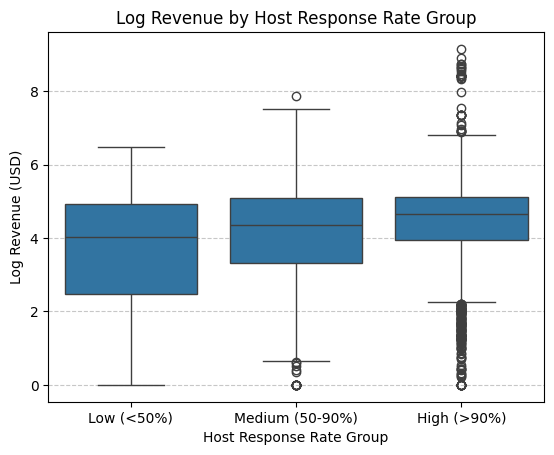

In [ ]:
listings_df['log_revenue'] = np.log1p(listings_df['revenue'])
sns.boxplot(x='response_rate_group', y='log_revenue', data=listings_df)
plt.title("Log Revenue by Host Response Rate Group")
plt.xlabel("Host Response Rate Group")
plt.ylabel("Log Revenue (USD)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- The spread (range) of revenue appears larger in the `High (>90%)` group, with several outliers at significantly higher revenue levels. This suggests that some high-response-rate hosts achieve exceptionally high revenues.
- Outliers may inflate the variance, which could have contributed to the non-significant result in the ANOVA test.

**Hypothesis:**

- Null Hypothesis (H₀): Listings with specific amenities have no difference in occupancy rates compared to those without.
- Alternative Hypothesis (H₁): Listings with specific amenities have significantly different occupancy rates.

**Pets Allowed:**

In [ ]:
# Merge the 'amenities' column from listings_df into listings_with_occupancy
listings_with_occupancy = listings_with_occupancy.merge(
    listings_df[['id', 'amenities']],
    left_on='id',  
    right_on='id',
    how='left'
)

In [ ]:
# Filter groups based on Pets allowed availability
group_A = listings_with_occupancy[listings_with_occupancy['amenities'].str.contains('Pets allowed') == False]['occupancy_rate']
group_B = listings_with_occupancy[listings_with_occupancy['amenities'].str.contains('Pets allowed')]['occupancy_rate']

# Perform A/B testing for Pets allowed impact
ab_testing(group_A, group_B, test_name="Pets allowed impact on Occupancy Rate")

Starting A/B Testing for: Pets allowed impact on Occupancy Rate

Step 1: Testing Normality using Shapiro-Wilk Test
Group A: Statistic=0.8682, p-value=0.0000
Group B: Statistic=0.8898, p-value=0.0000
At least one group is not normally distributed (p <= 0.05). Proceeding with non-parametric tests.

Step 3: Performing Mann-Whitney U Test
Mann-Whitney U Test: Statistic=2139368.5000, p-value=0.0073
Result: Statistically significant difference between the groups (p <= 0.05).



Listings with `Pets allowed` tend to have higher occupancy rates. This highlights the importance of pet friendliness in attracting bookings.

**Essentials:**

In [188]:
# Filter groups based on Pets allowed availability
group_A = listings_with_occupancy[listings_with_occupancy['amenities'].str.contains('Essentials') == False]['occupancy_rate']
group_B = listings_with_occupancy[listings_with_occupancy['amenities'].str.contains('Essentials')]['occupancy_rate']

# Perform A/B testing for Pets allowed impact
ab_testing(group_A, group_B, test_name="Essentials available impact on Occupancy Rate")

Starting A/B Testing for: Essentials available impact on Occupancy Rate

Step 1: Testing Normality using Shapiro-Wilk Test
Group A: Statistic=0.8621, p-value=0.0000
Group B: Statistic=0.8731, p-value=0.0000
At least one group is not normally distributed (p <= 0.05). Proceeding with non-parametric tests.

Step 3: Performing Mann-Whitney U Test
Mann-Whitney U Test: Statistic=2339792.0000, p-value=0.4875
Result: No statistically significant difference between the groups (p > 0.05).



Listings with `Essentials` do not show a significant impact on occupancy rates. This suggests that guest often pack their own essentials.

**Dishwasher:**

In [190]:
# Filter groups based on Pets allowed availability
group_A = listings_with_occupancy[listings_with_occupancy['amenities'].str.contains('Dishwasher') == False]['occupancy_rate']
group_B = listings_with_occupancy[listings_with_occupancy['amenities'].str.contains('Dishwasher')]['occupancy_rate']

# Perform A/B testing for Pets allowed impact
ab_testing(group_A, group_B, test_name="Dishwasher available impact on Occupancy Rate")

Starting A/B Testing for: Dishwasher available impact on Occupancy Rate

Step 1: Testing Normality using Shapiro-Wilk Test
Group A: Statistic=0.8621, p-value=0.0000
Group B: Statistic=0.8835, p-value=0.0000
At least one group is not normally distributed (p <= 0.05). Proceeding with non-parametric tests.

Step 3: Performing Mann-Whitney U Test
Mann-Whitney U Test: Statistic=4213162.0000, p-value=0.0008
Result: Statistically significant difference between the groups (p <= 0.05).



Listings with `Dishwasher` tend to have higher occupancy rates. This highlights the importance of comfort and modernity in attracting bookings.

In [194]:
# Merge the 'availability_365' column from listings_df into listings_with_occupancy
listings_with_occupancy = listings_with_occupancy.merge(
    listings_df[['id', 'availability_365']],
    left_on='id',  
    right_on='id',
    how='left'
)

In [ ]:
# Calculate revenue
listings_with_occupancy['revenue'] = (
    listings_with_occupancy['price'] *
    listings_with_occupancy['occupancy_rate'] *
    listings_with_occupancy['availability_365']
)

In [ ]:
# Extract all unique amenities

all_amenities = set()
listings_with_occupancy['amenities'].dropna().apply(
    lambda x: all_amenities.update(ast.literal_eval(x))
)
print(f"Total unique amenities: {len(all_amenities)}")

Total unique amenities: 2136


**Top Performing Amenities:**

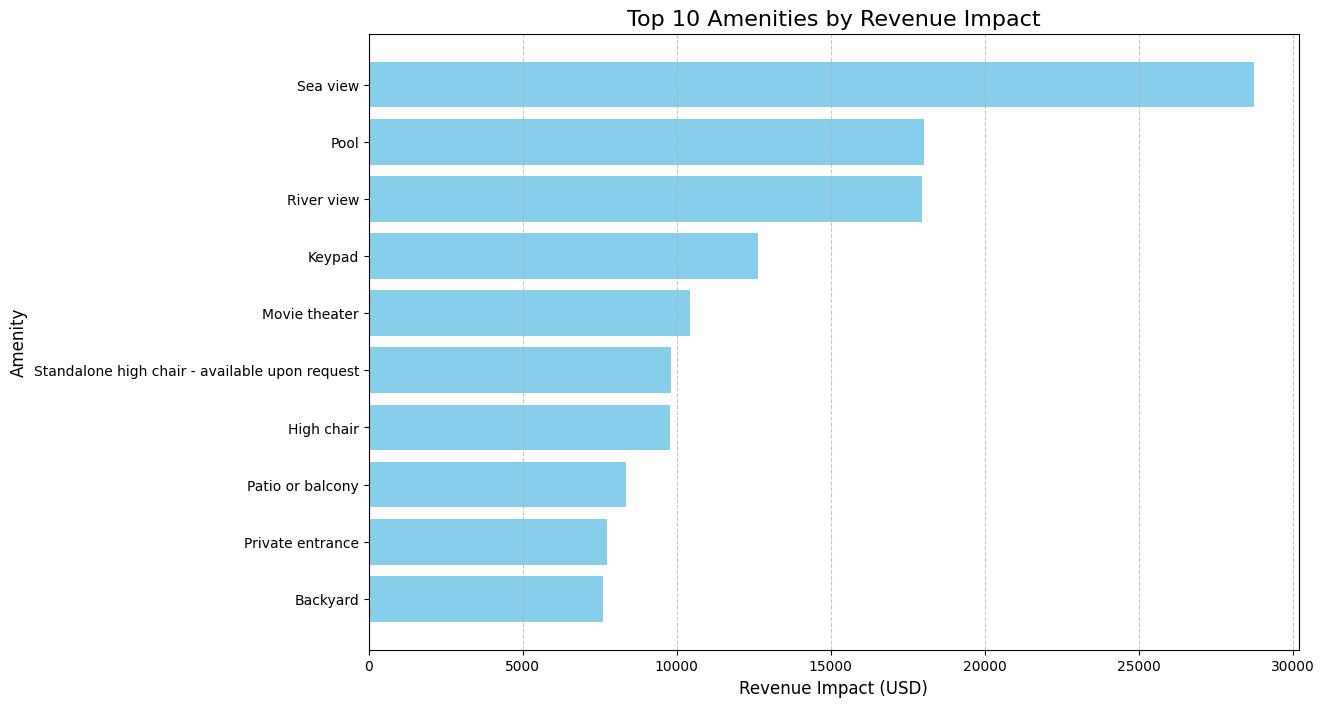

In [ ]:
def visualize_top_amenities(listings_with_occupancy, top_n=10, amenities_column='amenities', revenue_column='revenue'):
    """
    Visualize the top-performing amenities by revenue impact.
    Parameters:
        listings_with_occupancy (DataFrame): Data containing amenities and revenue information.
        top_n (int): Number of top-performing amenities to display.
        amenities_column (str): Name of the column containing amenities.
        revenue_column (str): Name of the column containing revenue.
    """

    # Extract all unique amenities
    all_amenities = set()
    listings_with_occupancy[amenities_column].dropna().apply(
        lambda x: all_amenities.update(ast.literal_eval(x))
    )
    
    # Prepare data for visualization
    results = []
    for amenity in all_amenities:
        # Escape special characters in the amenity name
        escaped_amenity = re.escape(amenity)
        
        # Group A: Listings without the amenity
        group_A = listings_with_occupancy[
            ~listings_with_occupancy[amenities_column].str.contains(escaped_amenity, na=False, regex=True)
        ][revenue_column]
        
        # Group B: Listings with the amenity
        group_B = listings_with_occupancy[
            listings_with_occupancy[amenities_column].str.contains(escaped_amenity, na=False, regex=True)
        ][revenue_column]
        
        if len(group_A) < 30 or len(group_B) < 30:
            # Skip if insufficient data
            continue
        
        # Calculate mean revenue for each group
        avg_revenue_no = group_A.mean()
        avg_revenue_yes = group_B.mean()
        
        # Append to results
        results.append({
            'Amenity': amenity,
            'Impact': avg_revenue_yes - avg_revenue_no
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by revenue impact and select top N amenities
    top_amenities = results_df.sort_values(by='Impact', ascending=False).head(top_n)
    
    # Plot bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(top_amenities['Amenity'], top_amenities['Impact'], color='skyblue')
    plt.xlabel('Revenue Impact (USD)', fontsize=12)
    plt.ylabel('Amenity', fontsize=12)
    plt.title(f'Top {top_n} Amenities by Revenue Impact', fontsize=16)
    plt.gca().invert_yaxis()  # Reverse order to show highest impact at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Run the visualization for top 10 amenities
visualize_top_amenities(listings_with_occupancy, top_n=10)

- Top Revenue-Driving Amenities:

    - Sea View: This amenity has the highest revenue impact by far, suggesting that properties with a sea view attract significantly higher revenue than those without.
    - Pool and River View: These are also top-performing amenities. They add substantial value, likely due to their association with luxury or leisure.

- Practical or Family-Oriented Amenities:

    - Standalone High Chair and High Chair: These amenities also show a strong impact, indicating demand from families traveling with children. This insight can be leveraged to target a family-friendly audience.
    - Patio or Balcony and Backyard: Outdoor spaces appear to increase revenue, possibly because they are particularly desirable in scenic or urban areas, and possibly caters to smokers.

##### **Recommendations:**

- Insights for Hosts:

    - Adding family-oriented amenities (e.g., high chairs) can help attract and retain family travelers.
    - Listings with luxury amenities like a pool or a movie theater can command premium prices.

- Strategic Implications:

    - Geographic Impact: Hosts in areas with natural scenery (e.g., sea, rivers) should highlight these features to maximize revenue.
    - Targeted Upgrades: For hosts seeking to increase their revenue, adding practical or family-friendly amenities may be a cost-effective way to attract higher-paying guests.

#### **Step 12 Regression Analysis:**

In [ ]:
# Step 1: Get all unique neighborhoods and room types from the data
neighborhoods = listings_df['neighbourhood_cleansed'].unique()
room_types = listings_df['room_type'].unique()

# Step 2: Create a DataFrame with all combinations of neighborhoods, room types, and other fixed features
predictions_data = []
for neighborhood in neighborhoods:
    for room_type in room_types:
        predictions_data.append({
            'review_scores_rating': 4.5,  # Fixed feature for all predictions
            'availability_365': 200,     # Fixed feature for all predictions
            'neighbourhood_cleansed': neighborhood,
            'room_type': room_type
        })

# Convert to DataFrame
predictions_df = pd.DataFrame(predictions_data)

# Step 3: One-hot encode the new data to match the training data structure
predictions_encoded = pd.get_dummies(predictions_df, columns=['neighbourhood_cleansed', 'room_type'])

# Ensure the new data matches the columns of X_train
predictions_encoded = predictions_encoded.reindex(columns=X_train.columns, fill_value=0)

# Step 4: Predict prices using both models
predictions_df['Optimal Price (Linear Regression)'] = lin_reg.predict(predictions_encoded)
predictions_df['Optimal Price (Random Forest)'] = rf_model.predict(predictions_encoded)

# Step 5: Display the DataFrame
predictions_df.head(20)

,review_scores_rating,availability_365,neighbourhood_cleansed,room_type,Optimal Price (Linear Regression),Optimal Price (Random Forest)
0,4.5,200,"Old Town, Princes Street and Leith Street",Entire home/apt,269.769308,196.38
1,4.5,200,"Old Town, Princes Street and Leith Street",Private room,133.407664,106.17
2,4.5,200,"Old Town, Princes Street and Leith Street",Hotel room,166.285818,114.42
3,4.5,200,"Old Town, Princes Street and Leith Street",Shared room,676.300285,816.87
4,4.5,200,"Canongate, Southside and Dumbiedykes",Entire home/apt,245.837195,225.03
5,4.5,200,"Canongate, Southside and Dumbiedykes",Private room,109.475550,77.65
6,4.5,200,"Canongate, Southside and Dumbiedykes",Hotel room,142.353704,220.50
7,4.5,200,"Canongate, Southside and Dumbiedykes",Shared room,652.368171,735.77
8,4.5,200,Joppa,Entire home/apt,237.305316,161.67
9,4.5,200,Joppa,Private room,100.943671,77.92


- **Neighborhoods:**
    - `Trinity` and `Portobello` have some of the highest predicted optimal prices, especially for shared and entire home/apartment options.
    - `Granton South and Wardieburn` and `Baberton and Juniper Green` show lower predictions for private rooms compared to the city center neighborhoods.

- **Room Types:**

    - `Entire home/apartment` listings tend to command higher prices compared to private rooms, hotel rooms, and shared rooms.
    - `Shared rooms`, though not as common, display significant pricing variability, with some high-end shared rooms in neighborhoods like Trinity.

- **Model Differences (Linear Regression vs. Random Forest):**

    - `Random Forest` appears to provide slightly more nuanced pricing for high-end neighborhoods, as seen in Trinity and Portobello.
    - `Linear Regression` offers more conservative predictions, especially for shared room options, which Random Forest prices significantly higher in high-demand neighborhoods.

- **Amenity-Driven Pricing:**

    - High predicted prices for entire home/apartments in neighborhoods such as Cramond and Queensferry could reflect `premium amenities` and/or views (e.g., sea views).

- **Optimal Pricing Gaps:**

    - Private room pricing across models remains relatively stable but varies significantly between neighborhoods.

C:\Users\inesc\AppData\Local\Temp\ipykernel_17932\1203629112.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



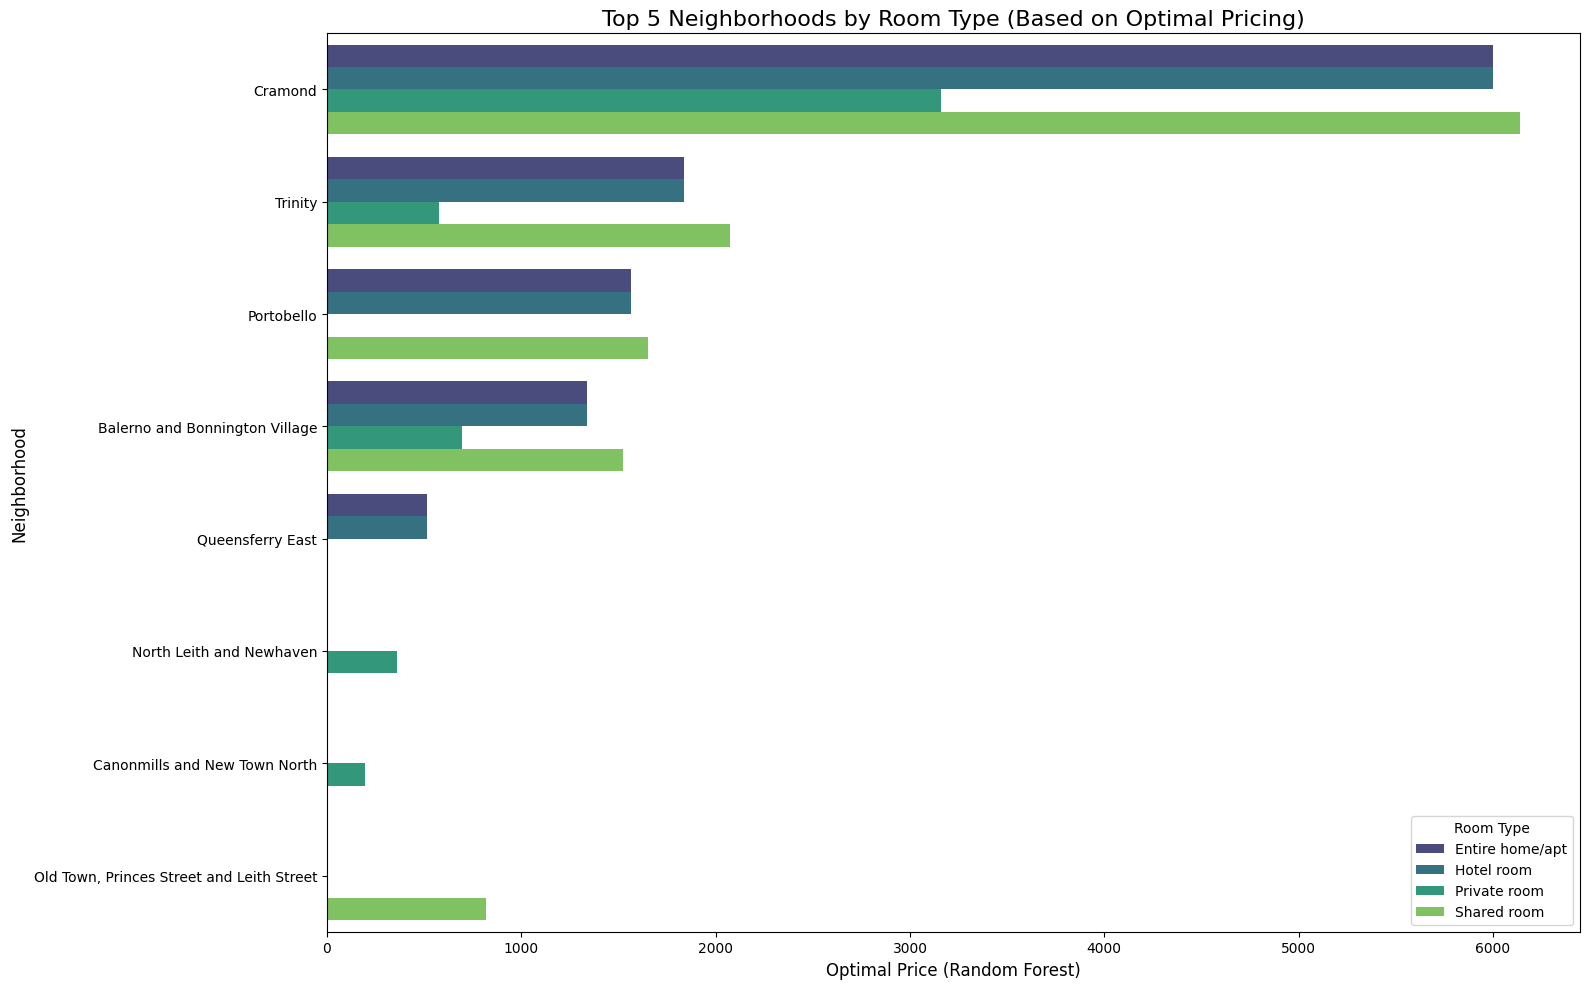

In [229]:
# Identify the top 5 neighborhoods for each room type based on Random Forest predictions
top_5_neighborhoods = (
    predictions_df.groupby('room_type', group_keys=False)
    .apply(lambda group: group.nlargest(5, 'Optimal Price (Random Forest)'))
)

# Create a bar plot to visualize the top 5 neighborhoods for each room type
plt.figure(figsize=(16, 10))
sns.barplot(
    data=top_5_neighborhoods,
    x='Optimal Price (Random Forest)',
    y='neighbourhood_cleansed',
    hue='room_type',
    dodge=True,
    palette='viridis'
)

plt.title("Top 5 Neighborhoods by Room Type (Based on Optimal Pricing)", fontsize=16)
plt.xlabel("Optimal Price (Random Forest)", fontsize=12)
plt.ylabel("Neighborhood", fontsize=12)
plt.legend(title="Room Type", fontsize=10)
plt.tight_layout()
plt.show()


##### **Recommendations:**

- Owners in Cramond should leverage premium pricing strategies.
- Investors may consider developing shared-room facilities in Trinity and Portobello, where higher prices are feasible.

#### **Step 13: Classification Analysis (Occupancy Prediction)**

In [ ]:
# Remove duplicate columns
calendar = calendar_df.loc[:, ~calendar_df.columns.duplicated()]
listings = listings_df.loc[:, ~listings_df.columns.duplicated()]

# Rename 'id' to 'listing_id' in listings
if 'id' in listings.columns:
    listings.rename(columns={'id': 'listing_id'}, inplace=True)

# Ensure 'listing_id' exists in both DataFrames
if 'listing_id' not in calendar.columns or 'listing_id' not in listings.columns:
    raise KeyError("The 'listing_id' column is missing in one of the DataFrames!")

# Check for data type consistency
calendar['listing_id'] = calendar['listing_id'].astype(str)
listings['listing_id'] = listings['listing_id'].astype(str)

# Perform the merge
merged_df = pd.merge(calendar, listings, on='listing_id', how='inner')

print("Successfully merged DataFrame:")
print(merged_df.info())

Successfully merged DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109562 entries, 0 to 2109561
Data columns (total 79 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   listing_id                                    object 
 1   date                                          object 
 2   available                                     object 
 3   price_x                                       object 
 4   minimum_nights_x                              int64  
 5   maximum_nights_x                              int64  
 6   season                                        object 
 7   listing_url                                   object 
 8   scrape_id                                     int64  
 9   last_scraped                                  object 
 10  source                                        object 
 11  name                                          object 
 12  description              

In [ ]:
# Select relevant features for classification
features = [
    'price_x', 'season', 'day_of_week', 'month', 'neighbourhood_cleansed',
    'review_scores_rating', 'review_scores_value', 'review_scores_cleanliness'
]
target = 'is_booked'

# Extract the required data
data = merged_df[features + [target]].copy()

# Convert `price_x` to numeric
data['price_x'] = data['price_x'].replace('[\$,]', '', regex=True).astype(float)

# Drop rows with missing values
data.dropna(inplace=True)

# Verify the prepared dataset
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109562 entries, 0 to 2109561
Data columns (total 9 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   price_x                    float64
 1   season                     object 
 2   day_of_week                int32  
 3   month                      int32  
 4   neighbourhood_cleansed     object 
 5   review_scores_rating       float64
 6   review_scores_value        float64
 7   review_scores_cleanliness  float64
 8   is_booked                  int64  
dtypes: float64(4), int32(2), int64(1), object(2)
memory usage: 128.8+ MB
None
   price_x  season  day_of_week  month neighbourhood_cleansed  \
0    120.0  Autumn            4      9              Abbeyhill   
1    120.0  Autumn            5      9              Abbeyhill   
2    120.0  Autumn            6      9              Abbeyhill   
3    120.0  Autumn            0      9              Abbeyhill   
4    120.0  Autumn            1      9      

In [ ]:
# Define feature types
num_features = ['price_x', 'review_scores_rating', 'review_scores_value', 'review_scores_cleanliness']
cat_features = ['season', 'day_of_week', 'month', 'neighbourhood_cleansed']

# Preprocessing pipeline
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Separate features and target
X = data[features]
y = data[target]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print("Preprocessed training data shape:", X_train_preprocessed.shape)

Preprocessed training data shape: (1687649, 138)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_preprocessed, y_train)

# Predict on test set
y_pred = model.predict(X_test_preprocessed)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.19      0.29    146867
           1       0.68      0.92      0.78    275046

    accuracy                           0.67    421913
   macro avg       0.62      0.56      0.54    421913
weighted avg       0.64      0.67      0.61    421913

Accuracy Score: 0.6675546854446296


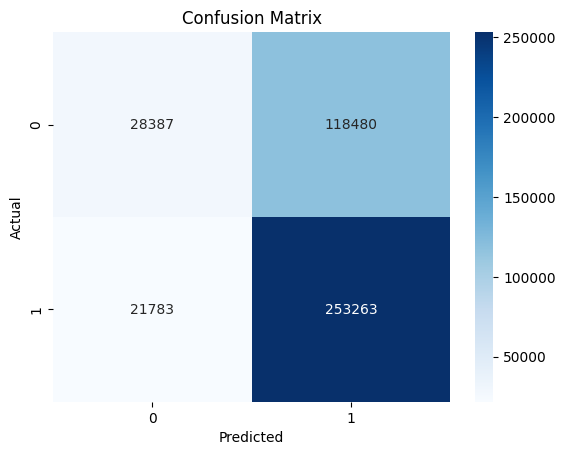

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- The dataset is imbalanced, with more bookings (1) than non-bookings (0).
    - The model performs significantly better at predicting bookings (1) than non-bookings (0).

- The model is excellent at catching most bookings (92% recall for 1).

- Many non-bookings (0) are incorrectly predicted as bookings, as reflected in the high false positive rate.

##### **Random Forest:**

In [277]:
# Remove missing columns from the feature list
selected_features = ['price_x', 'review_scores_value', 'day_of_week', 'month', 'season']

# Filter out any non-existent features from the DataFrame
selected_features = [col for col in selected_features if col in data.columns]
print("Selected Features:", selected_features)

Selected Features: ['price_x', 'review_scores_value', 'day_of_week', 'month', 'season']


In [ ]:
# Rebuild preprocessing pipeline with existing features
num_features = [col for col in ['price_x', 'review_scores_value'] if col in data.columns]
cat_features = [col for col in ['season', 'day_of_week', 'month'] if col in data.columns]

print("Numerical Features:", num_features)
print("Categorical Features:", cat_features)

# Define the transformers
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

Numerical Features: ['price_x', 'review_scores_value']
Categorical Features: ['season', 'day_of_week', 'month']


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model with optimized parameters
rf_model_optimized = RandomForestClassifier(
    n_estimators=50,        # Fewer trees for faster computation
    max_depth=10,           # Limit depth of trees
    random_state=42,        # Ensure reproducibility
    class_weight='balanced',# Handle class imbalance
    n_jobs=-1               # Use all CPU cores
)

In [ ]:
# Preprocess the training and test sets
X_train_reduced_preprocessed = preprocessor.fit_transform(X_train_reduced)
X_test_reduced_preprocessed = preprocessor.transform(X_test_reduced)

In [ ]:
# Train the Random Forest model
rf_model_optimized.fit(X_train_reduced_preprocessed, y_train)

# Make predictions on the test set
y_pred_rf_optimized = rf_model_optimized.predict(X_test_reduced_preprocessed)

# Evaluate the model
print("Optimized Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_optimized))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf_optimized))

Optimized Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.66      0.53    146867
           1       0.76      0.56      0.65    275046

    accuracy                           0.60    421913
   macro avg       0.60      0.61      0.59    421913
weighted avg       0.65      0.60      0.61    421913

Accuracy Score: 0.5975307705617035


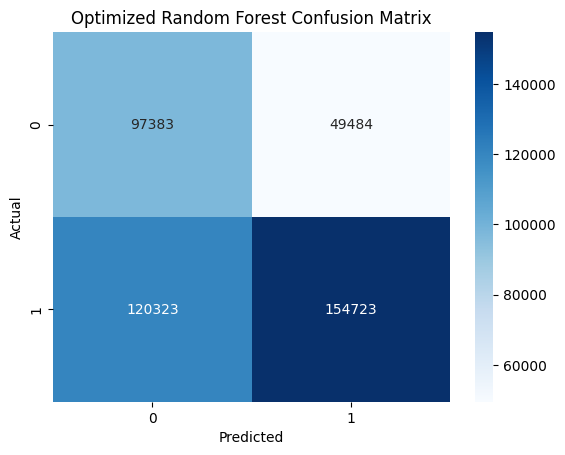

In [ ]:
# Confusion matrix
cm_rf_optimized = confusion_matrix(y_test, y_pred_rf_optimized)

sns.heatmap(cm_rf_optimized, annot=True, fmt='d', cmap='Blues')
plt.title("Optimized Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- The model performs better for predicting 1 (booked) than 0 (not booked).
    - This could be because 1 (booked) is more prevalent in the dataset, and the model naturally learns to favor the majority class.

- The accuracy and weighted F1-scores suggest the model is moderately effective but has room for improvement, particularly for 0 predictions.

#### **Step 14: Clustering (Property Segmentation)**

In [ ]:
# Select relevant features
clustering_features = ['price_x', 'room_type', 'review_scores_rating', 'neighbourhood_cleansed']

# Filter the dataset for clustering features
clustering_data = merged_df[clustering_features].dropna()

print(clustering_data.info())
print(clustering_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109562 entries, 0 to 2109561
Data columns (total 4 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   price_x                 object 
 1   room_type               object 
 2   review_scores_rating    float64
 3   neighbourhood_cleansed  object 
dtypes: float64(1), object(3)
memory usage: 64.4+ MB
None
   price_x        room_type  review_scores_rating neighbourhood_cleansed
0  $120.00  Entire home/apt                  4.56              Abbeyhill
1  $120.00  Entire home/apt                  4.56              Abbeyhill
2  $120.00  Entire home/apt                  4.56              Abbeyhill
3  $120.00  Entire home/apt                  4.56              Abbeyhill
4  $120.00  Entire home/apt                  4.56              Abbeyhill


In [ ]:
# Remove dollar signs and commas from price and convert to float
clustering_data['price_x'] = clustering_data['price_x'].replace('[\$,]', '', regex=True).astype(float)

print(clustering_data['price_x'].head())

0    120.0
1    120.0
2    120.0
3    120.0
4    120.0
Name: price_x, dtype: float64


In [ ]:
# Define preprocessing
num_features = ['price_x', 'review_scores_rating']
cat_features = ['room_type', 'neighbourhood_cleansed']

# Normalize numerical features and encode categorical features
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# Apply preprocessing
clustering_data_preprocessed = preprocessor.fit_transform(clustering_data)

print("Preprocessed Data Shape:", clustering_data_preprocessed.shape)

Preprocessed Data Shape: (2109562, 117)


##### **K-Means Clustering:**

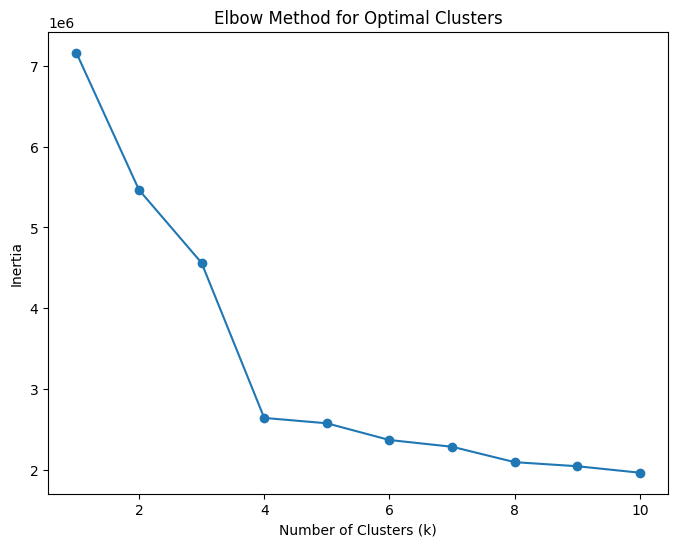

In [ ]:
# Use Elbow Method to find the optimal number of clusters
inertia = []
for k in range(1, 11):  # Test cluster sizes from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_preprocessed)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# Reduce dimensionality with PCA
pca = PCA(n_components=10, random_state=42)
reduced_data = pca.fit_transform(clustering_data_preprocessed)

# Apply MiniBatchKMeans
mini_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1000)
clusters = mini_kmeans.fit_predict(reduced_data)

# Add cluster assignments to the original data
clustering_data['Cluster'] = clusters

# Exclude non-numeric columns for group analysis
numeric_columns = clustering_data.select_dtypes(include=['number'])
cluster_means = numeric_columns.groupby(clustering_data['Cluster']).mean()

print(cluster_means)


             price_x  review_scores_rating  Cluster
Cluster                                            
0          96.605962              4.797259      0.0
1         299.344823              0.022390      1.0
2        7387.083333              4.007292      2.0
3         258.299840              4.761197      3.0


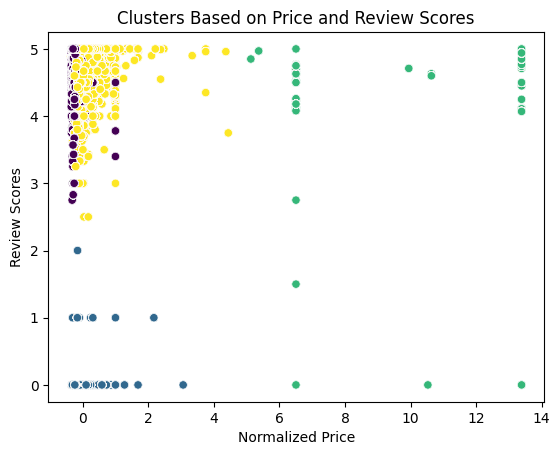

In [ ]:
sns.scatterplot(
    data=clustering_data,
    x='price_x_normalized',
    y='review_scores_rating',
    hue='Cluster',
    palette='viridis',
    legend=False  # Disable the legend
)
plt.title("Clusters Based on Price and Review Scores")
plt.xlabel("Normalized Price")
plt.ylabel("Review Scores")
plt.show()

**Interpretation of Clusters:**

- Cluster 1 <p style="color: yellow;">(Yellow Cluster):</p>

    - Concentrated in the low-to-medium price range.
    - Represents properties with high review scores (above 4.0).
    - Likely comprises budget-friendly, high-quality properties.

- Cluster 2 <p style="color: green;">(Green Cluster):</p>

    - Spread across higher price ranges.
    - Represents premium or luxury properties with high review scores.

- Cluster 3 <p style="color: purple;">(Purple Cluster):</p>

    - Concentrated in very low price ranges.
    - Represents lower-quality listings or budget properties with varying review scores.

- Cluster 4 <p style="color: blue;">(Dark Blue Cluster):</p>

    - Found across low price ranges but with low review scores.
    - Represents potentially poorly maintained or unpopular properties.


##### **Business Insights:**


- The clustering segments listings into different categories:

    - Budget-Friendly (High Quality)
    - Luxury/High-End Properties
    - Low-Quality Listings

##### **Recommendations:**

- Focus on improving review scores for properties in low-price, low-score clusters (e.g., dark blue cluster).
- Market premium listings (e.g., green cluster) to attract high-spending customers.


#### **Step 15: Revenue Forecasting:**

In [20]:
# Convert 'available' to a numeric indicator: 1 = booked (f), 0 = not booked (t)
calendar['is_booked'] = (calendar['available'] == 'f').astype(int)

# Calculate revenue only for booked dates
calendar['price_numeric'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['revenue'] = calendar['price_numeric'] * calendar['is_booked']

# Aggregate revenue by date for a property
revenue_data = calendar.groupby(['date'])['revenue'].sum().reset_index()

# Inspect the revenue data
print(revenue_data.head())


        date    revenue
0 2024-09-13  1499617.0
1 2024-09-14  1442750.0
2 2024-09-15  1308663.0
3 2024-09-16  1292036.0
4 2024-09-17  1313297.0


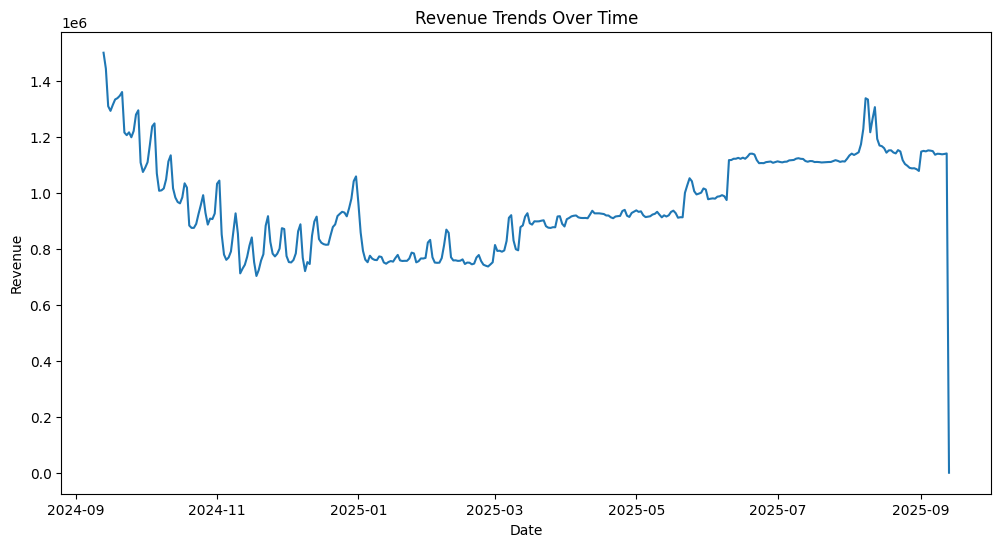

In [21]:
# Plot revenue over time
plt.figure(figsize=(12, 6))
plt.plot(revenue_data['date'], revenue_data['revenue'])
plt.title("Revenue Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

In [22]:
# Split data into train and test sets
train_size = int(len(revenue_data) * 0.8)
train_data = revenue_data[:train_size]
test_data = revenue_data[train_size:]

print(f"Train Size: {len(train_data)}, Test Size: {len(test_data)}")

Train Size: 292, Test Size: 74


ARIMA Mean Squared Error: 19854886911.878567


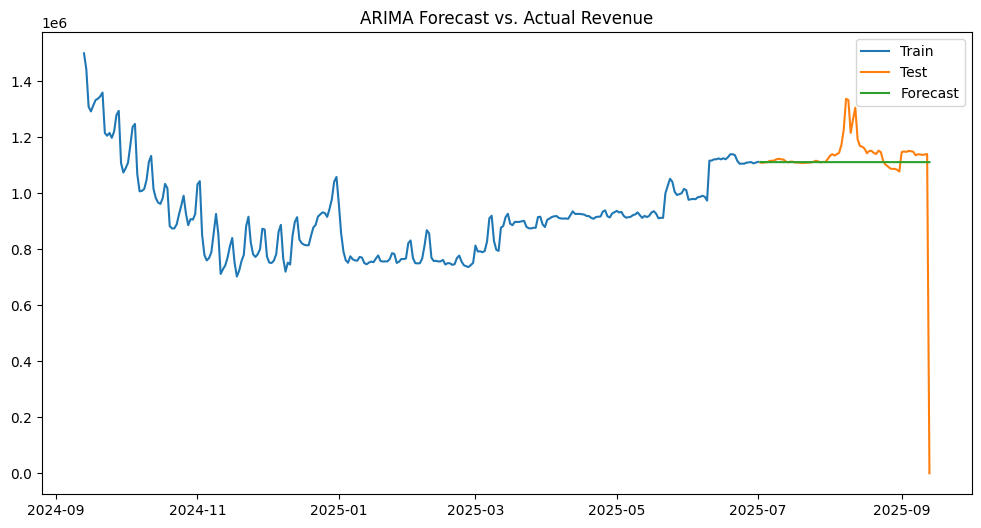

In [ ]:
# Fit ARIMA model
arima_model = ARIMA(train_data['revenue'], order=(5, 1, 0))  # Adjust order as necessary
arima_model_fit = arima_model.fit()

# Forecast
forecast = arima_model_fit.forecast(steps=len(test_data))

# Evaluate
mse = mean_squared_error(test_data['revenue'], forecast)
print(f"ARIMA Mean Squared Error: {mse}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['revenue'], label='Train')
plt.plot(test_data['date'], test_data['revenue'], label='Test')
plt.plot(test_data['date'], forecast, label='Forecast')
plt.legend()
plt.title("ARIMA Forecast vs. Actual Revenue")
plt.show()

- The `ARIMA` model captures the overall trend from the training data and provides a reasonable short-term forecast.
- However, it struggles with unexpected sharp changes in the test data, which is typical for ARIMA because it assumes stationarity and predictable patterns.

20:29:59 - cmdstanpy - INFO - Chain [1] start processing
20:29:59 - cmdstanpy - INFO - Chain [1] done processing


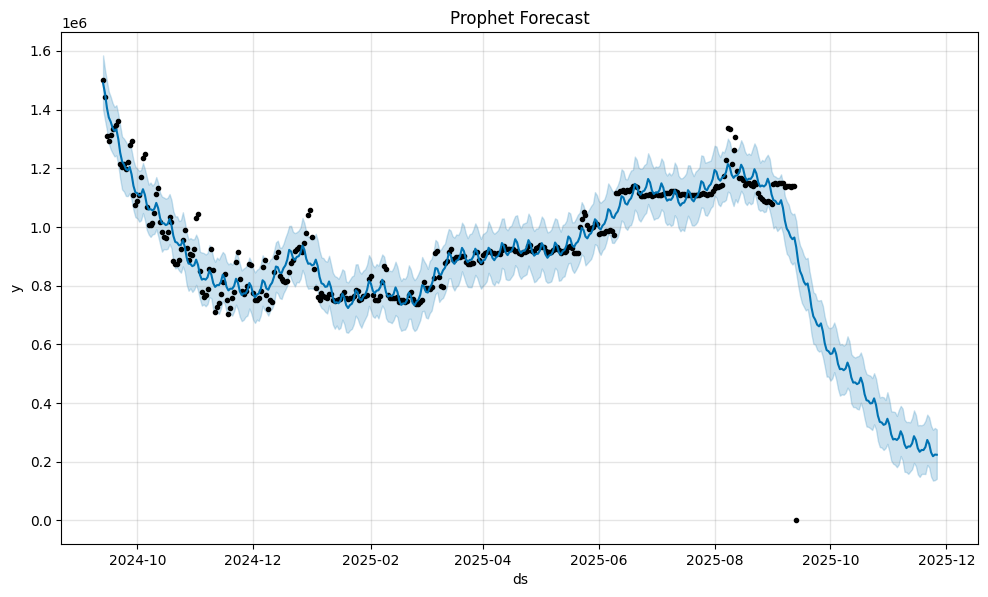

In [ ]:
# Prepare data for Prophet
prophet_data = revenue_data.rename(columns={'date': 'ds', 'revenue': 'y'})

# Fit Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=True)
prophet_model.fit(prophet_data)

# Create future dataframe
future = prophet_model.make_future_dataframe(periods=len(test_data))
forecast = prophet_model.predict(future)

# Plot results
prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

- `Prophet` appears to perform well for capturing the overall trend and seasonality of revenue.
- The forecast closely follows the actual data in most cases, with reasonable deviations in the uncertainty intervals.
- The sharp decline near the end of the test period shows the missing data.

##### **Recommendations:**

- Increase prices during peaks to maximize revenue during high-demand months identified by the seasonal peaks.
- Offer discounts or promotions during predicted low-revenue months to improve occupancy rates.

## **Phase 5: Conclusions:**

#### **Step 16: Summary of Insights and Recommendations**

This project provides a range of insights and actionable recommendations tailored to revenue optimization for Airbnb listings in Edinburgh. Below are the summarized conclusions:

**1. Guest Satisfaction and Review Insights**

- Guests frequently highlight terms like "great," "clean," "comfortable," "lovely," and "perfect," indicating high satisfaction with many listings.

- Proximity to attractions like the Royal Mile and Edinburgh city center is a major driver of positive reviews.

- Cleanliness, spaciousness, and well-maintained amenities (e.g., kitchens, bedrooms) significantly enhance guest experiences.

- Words like "helpful," "responsive," and "friendly" suggest that good communication and hospitality from hosts are critical to guest satisfaction.

- A high occurrence of terms like "highly recommend" underscores the importance of exceeding guest expectations.

**2. Pricing and Revenue Optimization**

- Demand and pricing fluctuate significantly based on the time of year, with peak seasons requiring higher pricing strategies.

- Listings in neighborhoods closer to tourist attractions command higher prices. Pricing optimization should reflect this demand.

- Private and entire homes generally yield higher revenues compared to shared spaces. Prioritize offering these for premium pricing.

**3. Recommendations**

- Emphasize cleaning standards and upgrading basic amenities to improve guest reviews and justify higher prices.

- Provide training or tools to help hosts be more responsive and personable in their interactions with guests.

- Highlight key features like proximity to attractions, cleanliness, and amenities in listing descriptions.

- Offer incentives or loyalty programs to encourage repeat bookings from satisfied customers.

**4. Machine Learning Applications**

- Use predictive analytics to forecast revenue based on location, seasonality, and guest preferences.

- Implement dynamic pricing models to adjust rates in real-time based on occupancy, demand, and competitor pricing.

**5. Marketing Recommendations**

- Focus marketing efforts on high-demand periods and emphasize proximity to major attractions.

- Use guest testimonials and review highlights in promotional materials to attract new bookings.

- Design packages for specific guest types (e.g., families, business travelers) based on trends in preferences.